In [1]:
from IPython.display import clear_output
from typing import List, Optional

import datetime
import functools
import gpflow as gpf
import hydra
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import tensorflow as tf
import tensor_annotations.tensorflow as ttf
import tensorflow_probability as tfp

from gpflow import default_float, default_jitter
from gpflow.conditionals import uncertain_conditional, base_conditional
from matplotlib import cm
from numpy import random
from omegaconf import DictConfig
from simenvs import make

from modeopt.cost_functions import ControlQuadraticCostFunction, TargetStateCostFunction, StateDiffCostFunction, quadratic_cost_fn
from modeopt.controllers.utils import initialise_deterministic_trajectory, build_mode_variational_objective
from modeopt.controllers import TrajectoryOptimisationController
from modeopt.constraints import build_mode_chance_constraints_scipy
from modeopt.custom_types import Dataset
from modeopt.dynamics.conditionals import svgp_covariance_conditional
from modeopt.plotting import ModeOptContourPlotter
from modeopt.rollouts import rollout_controls_in_dynamics, rollout_controller_in_dynamics, rollout_controller_in_env, collect_data_from_env
from modeopt.trajectories import ControlTrajectoryDist
from modeopt.utils import model_from_DictConfig, combine_state_controls_to_input, append_zero_control
from modeopt.mode_opt import ModeOpt
from mogpe.keras.callbacks.tensorboard import PlotFn, TensorboardImageCallback
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting import MixtureOfSVGPExpertsContourPlotter
from mogpe.keras.utils import sample_mosvgpe_inducing_inputs_from_data, model_from_yaml

%matplotlib inline

tfd = tfp.distributions

CMAP = palettable.scientific.sequential.Bilbao_15.mpl_colormap

meaning_of_life = 42
tf.random.set_seed(meaning_of_life)
np.random.seed(meaning_of_life)

## Initialise environment

In [2]:
env_name = "velocity-controlled-point-mass/scenario-7"

In [3]:
env = make(env_name)
state_dim = env.observation_spec().shape[0]
control_dim = env.action_spec().shape[0]

No constant_error found in toml config so using default : 0.0


## ModeOpt config

In [4]:
start_state = np.array([[-1.0, -2.0]])
target_state = np.array([[1.7, 3.0]])
mode_satisfaction_prob = 0.8

## Sample initial data set from desired mode

(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)


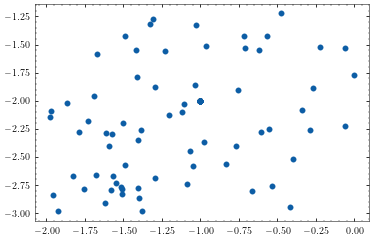

In [5]:
def sample_env_trajectories(horizon=15, num_trajectories=10):
    X, Y = [], []
    for i in range(num_trajectories):
        controls = np.random.uniform(
            env.action_spec().minimum,
            env.action_spec().maximum,
            (horizon, env.action_spec().shape[-1]),
        )
        X_, Y_ = collect_data_from_env(env, start_state=start_state, controls=controls)
        X.append(X_)
        Y.append(Y_)
    X = np.concatenate(X, 0)
    Y = np.concatenate(Y, 0)
    width = 1.0
    mask_1 = X[:, 0] > start_state[0, 0] - width
    mask_2 = X[:, 0] < start_state[0, 0] + width
    mask_3 = X[:, 1] > start_state[0, 1] - width
    mask_4 = X[:, 1] < start_state[0, 1] + width
    mask = mask_1 & mask_2 & mask_3 & mask_4
    X_trimmed = X[mask]
    Y_trimmed = Y[mask]
    print(X_trimmed.shape)
    print(Y_trimmed.shape)
    return (X_trimmed, Y_trimmed)

initial_dataset = sample_env_trajectories(horizon = 15, num_trajectories=50)
dataset = initial_dataset
plt.scatter(dataset[0][:, 0], dataset[0][:, 1])
plt.show()

## Train dynamics on initial data set or load from config

In [6]:
initial_num_epochs = 20000
# num_epochs = 300
num_epochs = 1500
# batch_size = 128
batch_size = initial_dataset[0].shape[0]
dynamics_logging_epoch_freq = 100

load_from_config = True
# load_from_config = False
yaml_cfg_filename = "./keras_configs/mode_opt_explore_scenario_7.yaml"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-29-18-14/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-13-33/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-14-22/ckpts"

In [7]:
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M') #  now
log_dir = os.path.join(f"./experiments/mvn-full-cov/explorative-prob-{mode_satisfaction_prob}", now_time)

In [8]:
if load_from_config:
    mode_optimiser = ModeOpt.load(load_ckpt_dir)
    mode_optimiser.log_dir = log_dir
else:
    mode_optimiser = model_from_yaml(yaml_cfg_filename, custom_objects={"ModeOpt": ModeOpt})
    mode_optimiser.dataset = (tf.constant(initial_dataset[0], dtype=default_float()),
                              tf.constant(initial_dataset[1], dtype=default_float())
                             )
    sample_mosvgpe_inducing_inputs_from_data(initial_dataset[0], mode_optimiser.dynamics.mosvgpe)
    mode_optimiser.dynamics_fit_kwargs.update({"epochs": initial_num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     dynamics_plotting_callbacks = build_contour_plotter_callbacks(mode_optimiser.dynamics.mosvgpe, logging_epoch_freq=dynamics_logging_epoch_freq, log_dir=mode_optimiser.log_dir)
#     mode_optimiser.add_dynamics_callbacks(dynamics_plotting_callbacks)
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.inducing_variable, False)
    mode_optimiser.optimise_dynamics()
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)

2022-04-13 21:01:46.413288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


setting desired mode to 1
╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════╕
│ name                                                           │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                    │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════╡
│ IndependentPosteriorMultiOutput.kernel.kernels[0].variance     │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.4978003107997662                       │
├────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ IndependentPosteriorMultiOutput.kerne

2022-04-13 21:01:46.739409: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-13 21:01:46.739421: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-13 21:01:46.739451: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Update the data set.

In [9]:
mode_optimiser.start_state = tf.constant(start_state, dtype=default_float())

Set the correct desired dynamics mode.

In [10]:
def which_desired_mode(mode_optimiser, initial_dataset):
    probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(initial_dataset[0])
    mean_probs = tf.reduce_mean(probs, 0)
    return int(tf.math.argmax(mean_probs))

desired_mode = which_desired_mode(mode_optimiser, initial_dataset)
print("Desired mode is {}".format(desired_mode))
mode_optimiser.desired_mode = desired_mode

Desired mode is 1


Save the learned dynamics model.

In [11]:
mode_optimiser.save()

## Configure the explorative controller

In [12]:
horizon = 15
max_iterations = 1000
keep_last_solution = True
keep_last_solution = False
method = "SLSQP"

In [13]:
terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 0.01
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 1.0
# control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 0.1
control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 1.0

# terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=start_state)
terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=target_state)
control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
state_diff_cost_fn = StateDiffCostFunction(weight_matrix=state_diff_cost_matrix, target_state=target_state)

cost_fn = control_cost_fn + state_diff_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = control_cost_fn
# cost_fn = control_cost_fn + state_diff_cost_fn + terminal_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = terminal_cost_fn + state_diff_cost_fn

In [14]:
def explorative_objective(initial_solution: ControlTrajectoryDist) -> ttf.Tensor0:
    control_means = initial_solution(variance=False)
    control_vars = None
    state_means, state_vars = rollout_controls_in_dynamics(
        dynamics=mode_optimiser.dynamics,
        start_state=start_state,
        control_means=control_means,
        control_vars=control_vars,
    )
    
    input_means, input_vars = combine_state_controls_to_input(
        state_means[1:, :], control_means, state_vars[1:, :], control_vars
    )
    h_means, h_vars = mode_optimiser.dynamics.mosvgpe.gating_network.gp.predict_f(input_means, full_cov=True)
    h_vars = h_vars + tf.eye(h_vars.shape[1], h_vars.shape[2], dtype=default_float()) * 1e-6
    h_dist = tfd.MultivariateNormalFullCovariance(h_means, h_vars[0, :, :]**2)
    gating_entropy = h_dist.entropy()
#     h_dist_diag = tfd.MultivariateNormalDiag(h_means, tf.linalg.diag_part(h_vars[0, :, :])**2)
#     h_dist = tfd.MultivariateNormalFullCovariance(h_means[:, mode_optimiser.desired_mode], h_vars[0, :, :])
#     gating_entropy_diag = h_dist_diag.entropy()
#     tf.print('mvn')
#     tf.print(tf.reduce_sum(gating_entropy))
#     tf.print('DIAG mvn')
#     tf.print(tf.reduce_sum(gating_entropy))
#     tf.print(cost_fn(state_means, control_means, state_vars, control_vars))
    return -tf.reduce_sum(gating_entropy) + cost_fn(state_means, control_means, state_vars, control_vars)

In [15]:
def find_initial_solution_in_desired_mode():
    fake_target_state_in_mode_idx = np.random.choice(np.arange(len(mode_optimiser.dataset[0])), size=1)
    fake_target_state_in_mode = mode_optimiser.dataset[0][fake_target_state_in_mode_idx[0], :state_dim]
    fake_target_state_in_mode = tf.constant([[0, -1]], dtype=default_float())
    
    terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100.0
    control_cost_matrix = tf.eye(control_dim, dtype=default_float())
    
    terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, 
                                               target_state=fake_target_state_in_mode)
    control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
    initial_cost_fn = terminal_cost_fn + control_cost_fn

    initial_solution = initialise_deterministic_trajectory(horizon, control_dim)
    objective_fn = build_mode_variational_objective(mode_optimiser.dynamics, initial_cost_fn, start_state)
    explorative_controller = TrajectoryOptimisationController(
        max_iterations=max_iterations,
        initial_solution=initial_solution,
        objective_fn=objective_fn,
        method=method,
    )
    explorative_controller.optimise()
    return explorative_controller.previous_solution

initial_solution_in_mode = find_initial_solution_in_desired_mode()

2022-04-13 21:01:47.061680: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Xnew.shape
(256, 15, 4)
gating_means.shape
(256, 15, 1)
input_mean.shape
(15, 4)
(15, 4)
var_exp: Tensor("Sum_218:0", shape=(15, 1), dtype=float64)
mode_var_exp: Tensor("Sum_219:0", shape=(), dtype=float64)


2022-04-13 21:02:06.676814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Optimisation result:
     fun: array([66.59696742])
     jac: array([2.69513992e-04, 7.56009729e-04, 5.53638984e-04, 6.17919925e-04,
       8.24734830e-05, 6.56961782e-04, 1.17365008e-04, 7.29399697e-04,
       4.05722417e-04, 7.39736557e-04, 4.61553437e-04, 6.91946622e-04,
       2.84344129e-04, 5.91346487e-04, 9.81022855e-05, 4.57220948e-04,
       7.90776870e-05, 4.21872280e-04, 1.69593489e-04, 5.53104525e-04,
       2.26450631e-04, 7.32156357e-04, 1.44979967e-04, 7.40807270e-04,
       7.21748549e-05, 4.30802069e-04, 1.85513109e-04, 2.63013167e-05,
       3.66076753e-04, 9.75111871e-05])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-0.23821481,  2.13424601, -0.13510465,  1.95088118, -0.07097346,
        1.82675821, -0.02716002,  1.7448613 ,  0.00669778,  1.69276623,
        0.03689614,  1.66185601,  0.0678676 ,  1.64643057,  0.10312259,
        1.6430313 ,  0.14580199,  1.65000104,  0.1990902 ,  

In [16]:
mode_chance_constraints = build_mode_chance_constraints_scipy(mode_optimiser.dynamics, 
                                                              start_state, 
                                                              horizon, 
                                                              control_dim=control_dim,
                                                              lower_bound=mode_satisfaction_prob)
explorative_controller = TrajectoryOptimisationController(
    max_iterations=max_iterations,
    initial_solution=initial_solution_in_mode,
    objective_fn=explorative_objective,
    keep_last_solution=keep_last_solution,
    constraints=[mode_chance_constraints],
    method=method,
)
mode_optimiser.explorative_controller = explorative_controller

## Configure plotter

In [17]:
def create_test_inputs(x_min=[-3, -3], x_max=[3, 3], input_dim=4, num_test: int = 1600, factor: float = 1.2):
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(x_min[0] * factor, x_max[0] * factor, sqrtN)
    yy = np.linspace(x_min[1] * factor, x_max[1] * factor, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    if input_dim > 2:
        zeros = np.zeros((num_test, input_dim - 2))
        test_inputs = np.concatenate([test_inputs, zeros], -1)
    return test_inputs, xx, yy

test_inputs, xx, yy = create_test_inputs()
plotter = ModeOptContourPlotter(mode_optimiser, test_inputs=test_inputs, static=False, explorative=True)

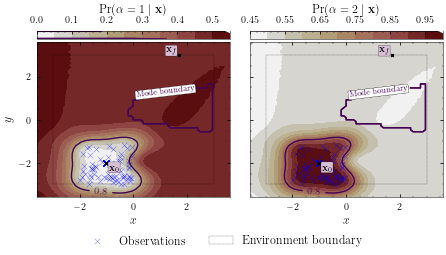

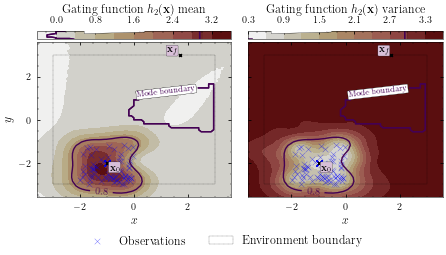

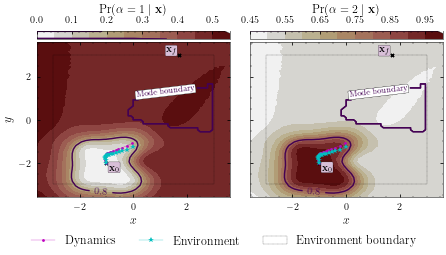

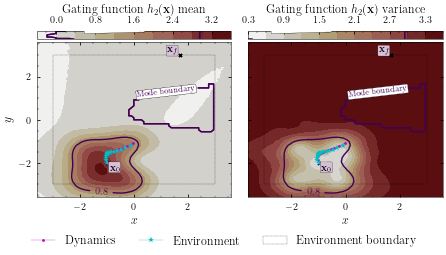

In [18]:
image_save_dir = os.path.join(mode_optimiser.log_dir, "images")
try:
    os.makedirs(image_save_dir)
except FileExistsError:
    pass

def plot_data_over_gating_network_and_save(step: int, epoch: int, save: bool = True):
    plotter.plot_data_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_mixing_probs_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_data_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_desired_gating_gp_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)

def plot_trajectories_over_gating_network_and_save(step: int, save: bool = True):
    plotter.plot_trajectories_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_mixing_probs_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_trajectories_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_desired_gating_gp_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)

plot_data_over_gating_network_and_save(step=0, epoch=0)
plot_trajectories_over_gating_network_and_save(step=0)

## Configure ModeOpt and callbacks

In [19]:
# mode_optimiser.dataset = (mode_optimiser.dataset[0][:130, :], mode_optimiser.dataset[1][:130, :])

In [20]:
# logging_epoch_freq = 60
num_epochs = 10000
logging_epoch_freq = math.floor((num_epochs)/5)
save_epoch_freq = math.floor((num_epochs)/5)
logging_epoch_freq = 1000
save_epoch_freq = 
num_steps = 35
dataset = initial_dataset
# batch_size = 128
batch_size = mode_optimiser.dataset[0].shape[0]

mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
mode_optimiser.dynamics_fit_kwargs

{'epochs': 10000, 'batch_size': 125, 'validation_split': 0.2}

Callbacks for dynamics learning.

In [21]:
class PlottingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % logging_epoch_freq == 0:
            plot_data_over_gating_network_and_save(step=step, epoch=epoch)

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % save_epoch_freq == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(mode_optimiser.ckpt_dir, "step_{}_epoch_{}".format(step, epoch)), save_format="tf")
            
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=1200,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
callbacks = [PlottingCallback(),
             CustomSaver(),
             early_stopping_cb,
#              tf.keras.callbacks.ModelCheckpoint(
#                  filepath=os.path.join(save_dir + "ckpts/ModeOptDynamics"),
#                  monitor="loss",
#                  save_format="tf",
#                  save_best_only=False,
#                  save_freq=500),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir)
            ]

2022-04-13 21:02:38.843535: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-13 21:02:38.843550: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-13 21:02:38.843953: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [22]:
mode_optimiser.dynamics(dataset[0]) # call ModeOptDynamics to build it for saving
mode_optimiser.dynamics_callbacks = []
mode_optimiser.add_dynamics_callbacks(callbacks)

In [23]:
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.experts_list[desired_mode].gp.kernel, False)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Optimisation result:
     fun: 145.83730448280733
     jac: array([-19.42479227, -50.68961458, -19.05349599, -50.71870237,
       -19.75586154, -51.11907378, -20.94586879, -50.98699471,
       -23.43206321, -43.46048026, -24.194763  , -36.93593752,
       -24.5146752 , -22.02774216, -25.0507814 , -21.63473001,
       -26.35003675, -22.80157962, -26.23148209, -23.61322573,
       -25.52343933, -24.51949337, -16.9608255 , -17.06392938,
       -13.2099699 ,  -2.00500143, -10.6405982 ,  -2.14647746,
        -6.83105923,  -1.83856938])
 message: 'Optimization terminated successfully'
    nfev: 113
     nit: 67
    njev: 67
  status: 0
 success: True
       x: array([-2.32170751,  1.98682991, -1.95067177,  2.2900693 , -0.45477243,
        3.37020331,  1.39135054,  2.55421822,  1.64392434,  1.87685674,
        1.55806885,

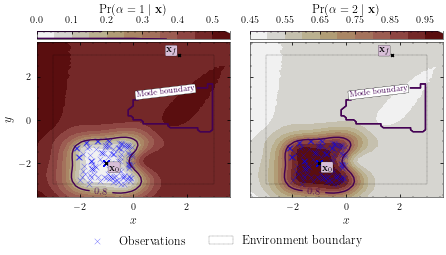

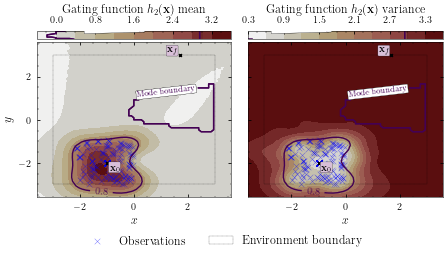

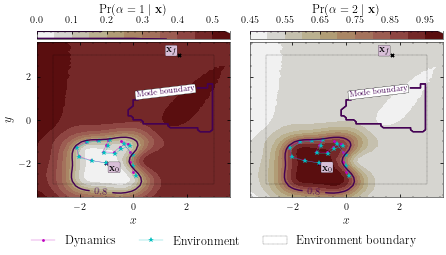

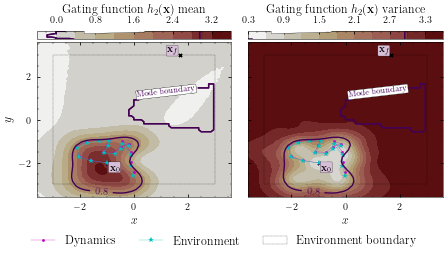

Epoch 1/10000
Mixing probs: (1, None, 2)
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Experts probs: (None, None, 2)
Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
3/3 [==============================] - ETA: 0s - loss: -607.5227

2022-04-13 21:05:14.585529: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-13 21:05:14.585544: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-13 21:05:14.599123: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-13 21:05:14.618597: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-13 21:05:14.633470: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_05_14

2022-04-13 21:05:14.643373: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_05_14/dr-robots-mbp.local.trace.json.gz
2022-04-13 21:05:14.683049: I tensorflow/core/profiler/rp

Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
3/3 [==============================] - 19s 2s/step - loss: -607.5227 - val_loss: -691.5005
Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-13-21-01/ckpts/step_1_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
3/3 [==============================] - 0s 19ms/step - loss: -622.0459 - val_loss: -566.3060
Epoch 3/10000
3/3 [==============================] - 0s 19ms/step - loss: -625.7731 - val_loss: -706.0126
Epoch 4/10000
3/3 [==============================] - 0s 20ms/step - loss: -651.5821 - val_loss: -628.9222
Epoch 5/10000
3/3 [==============================] - 0s 17ms/step - loss: -657.8701 - val_loss: -624.9096
Epoch 6/10000
3/3 [==============================] - 0s 17ms/step - loss: -669.8372 - val_loss: -645.5190
Epoch 7/10000
3/3 [==============================] - 0s 18ms/step - loss: -677.6475 - val_loss: -691.1728
Epoch 8/10000
3/3 [==============================] - 0s 17ms/step - loss: -707.5469 - val_loss: -738.8544
Epoch 9/10000
3/3 [==============================] - 0s 17ms/step - loss: -677.9254 - val_loss: -727.7956
Epoch 10/10000
3/3 [==============================] - 0s 16ms/step - loss: -709.1797 - val_loss: -744.9199
Epoch 11/10000
3/3 [=========================

3/3 [==============================] - 0s 26ms/step - loss: -738.4110 - val_loss: -773.5391
Epoch 77/10000
3/3 [==============================] - 0s 23ms/step - loss: -717.6365 - val_loss: -741.3188
Epoch 78/10000
3/3 [==============================] - 0s 19ms/step - loss: -624.5216 - val_loss: -518.2638
Epoch 79/10000
3/3 [==============================] - 0s 33ms/step - loss: -622.1434 - val_loss: -456.8497
Epoch 80/10000
3/3 [==============================] - 0s 24ms/step - loss: -686.9521 - val_loss: -636.2699
Epoch 81/10000
3/3 [==============================] - 0s 23ms/step - loss: -689.9747 - val_loss: -72.4407
Epoch 82/10000
3/3 [==============================] - 0s 26ms/step - loss: -677.8318 - val_loss: -783.9122
Epoch 83/10000
3/3 [==============================] - 0s 21ms/step - loss: -653.5970 - val_loss: -173.5284
Epoch 84/10000
3/3 [==============================] - 0s 20ms/step - loss: -481.8414 - val_loss: -652.0853
Epoch 85/10000
3/3 [==============================] -

3/3 [==============================] - 0s 22ms/step - loss: -432.8105 - val_loss: -718.2861
Epoch 153/10000
3/3 [==============================] - 0s 21ms/step - loss: -51.9562 - val_loss: -540.7607
Epoch 154/10000
3/3 [==============================] - 0s 22ms/step - loss: -533.7345 - val_loss: -674.0544
Epoch 155/10000
3/3 [==============================] - 0s 21ms/step - loss: -490.7421 - val_loss: -574.7869
Epoch 156/10000
3/3 [==============================] - 0s 20ms/step - loss: -515.7166 - val_loss: -600.9494
Epoch 157/10000
3/3 [==============================] - 0s 21ms/step - loss: -429.4143 - val_loss: -563.0814
Epoch 158/10000
3/3 [==============================] - 0s 21ms/step - loss: -556.6783 - val_loss: -654.3455
Epoch 159/10000
3/3 [==============================] - 0s 23ms/step - loss: -547.7336 - val_loss: -442.9999
Epoch 160/10000
3/3 [==============================] - 0s 23ms/step - loss: -379.2026 - val_loss: -618.4427
Epoch 161/10000
3/3 [========================

3/3 [==============================] - 0s 21ms/step - loss: -191.5845 - val_loss: -228.5862
Epoch 229/10000
3/3 [==============================] - 0s 21ms/step - loss: -464.3434 - val_loss: -601.7806
Epoch 230/10000
3/3 [==============================] - 0s 20ms/step - loss: -564.4030 - val_loss: -584.9698
Epoch 231/10000
3/3 [==============================] - 0s 21ms/step - loss: -526.1361 - val_loss: -426.7656
Epoch 232/10000
3/3 [==============================] - 0s 21ms/step - loss: -388.8297 - val_loss: -642.1000
Epoch 233/10000
3/3 [==============================] - 0s 22ms/step - loss: -528.3316 - val_loss: -486.0654
Epoch 234/10000
3/3 [==============================] - 0s 22ms/step - loss: -544.6116 - val_loss: -585.8546
Epoch 235/10000
3/3 [==============================] - 0s 22ms/step - loss: -557.4465 - val_loss: -612.7511
Epoch 236/10000
3/3 [==============================] - 0s 21ms/step - loss: -511.4513 - val_loss: -601.7830
Epoch 237/10000
3/3 [=======================

3/3 [==============================] - 0s 23ms/step - loss: -668.8538 - val_loss: -610.7108
Epoch 305/10000
3/3 [==============================] - 0s 25ms/step - loss: -630.4098 - val_loss: -609.2027
Epoch 306/10000
3/3 [==============================] - 0s 26ms/step - loss: -526.0788 - val_loss: -708.1467
Epoch 307/10000
3/3 [==============================] - 0s 26ms/step - loss: -664.2870 - val_loss: -701.4510
Epoch 308/10000
3/3 [==============================] - 0s 25ms/step - loss: -661.4632 - val_loss: -720.1089
Epoch 309/10000
3/3 [==============================] - 0s 25ms/step - loss: -657.6633 - val_loss: -581.6897
Epoch 310/10000
3/3 [==============================] - 0s 25ms/step - loss: -642.2689 - val_loss: -606.1306
Epoch 311/10000
3/3 [==============================] - 0s 27ms/step - loss: -619.6422 - val_loss: -598.0461
Epoch 312/10000
3/3 [==============================] - 0s 25ms/step - loss: -694.5421 - val_loss: -700.6329
Epoch 313/10000
3/3 [=======================

3/3 [==============================] - 0s 23ms/step - loss: -497.9906 - val_loss: -658.8666
Epoch 381/10000
3/3 [==============================] - 0s 23ms/step - loss: -600.1376 - val_loss: -846.4892
Epoch 382/10000
3/3 [==============================] - 0s 23ms/step - loss: -612.1359 - val_loss: -108.8285
Epoch 383/10000
3/3 [==============================] - 0s 22ms/step - loss: -300.1272 - val_loss: -780.7602
Epoch 384/10000
3/3 [==============================] - 0s 23ms/step - loss: 13.4180 - val_loss: -52.7333
Epoch 385/10000
3/3 [==============================] - 0s 23ms/step - loss: -23.6598 - val_loss: -532.0593
Epoch 386/10000
3/3 [==============================] - 0s 23ms/step - loss: -33.9043 - val_loss: -284.9175
Epoch 387/10000
3/3 [==============================] - 0s 23ms/step - loss: 561.1479 - val_loss: -670.0722
Epoch 388/10000
3/3 [==============================] - 0s 23ms/step - loss: -168.0866 - val_loss: -190.3047
Epoch 389/10000
3/3 [=============================

3/3 [==============================] - 0s 22ms/step - loss: -160.4991 - val_loss: -533.6058
Epoch 457/10000
3/3 [==============================] - 0s 23ms/step - loss: -350.0487 - val_loss: -105.4143
Epoch 458/10000
3/3 [==============================] - 0s 24ms/step - loss: -550.0965 - val_loss: -253.9388
Epoch 459/10000
3/3 [==============================] - 0s 22ms/step - loss: -426.1523 - val_loss: -688.2953
Epoch 460/10000
3/3 [==============================] - 0s 23ms/step - loss: -188.0764 - val_loss: -93.5821
Epoch 461/10000
3/3 [==============================] - 0s 23ms/step - loss: -82.8285 - val_loss: -586.4073
Epoch 462/10000
3/3 [==============================] - 0s 24ms/step - loss: -502.8804 - val_loss: -347.5370
Epoch 463/10000
3/3 [==============================] - 0s 23ms/step - loss: -400.6193 - val_loss: -392.8147
Epoch 464/10000
3/3 [==============================] - 0s 23ms/step - loss: -548.4901 - val_loss: -342.7438
Epoch 465/10000
3/3 [=========================

Epoch 532/10000
3/3 [==============================] - 0s 25ms/step - loss: -737.7608 - val_loss: -673.2241
Epoch 533/10000
3/3 [==============================] - 0s 24ms/step - loss: -707.5426 - val_loss: -671.6990
Epoch 534/10000
3/3 [==============================] - 0s 24ms/step - loss: -767.3896 - val_loss: -815.4077
Epoch 535/10000
3/3 [==============================] - 0s 24ms/step - loss: -660.2146 - val_loss: -747.2929
Epoch 536/10000
3/3 [==============================] - 0s 25ms/step - loss: -708.2600 - val_loss: -532.7787
Epoch 537/10000
3/3 [==============================] - 0s 25ms/step - loss: -762.0212 - val_loss: -838.7977
Epoch 538/10000
3/3 [==============================] - 0s 24ms/step - loss: -723.3834 - val_loss: -680.7428
Epoch 539/10000
3/3 [==============================] - 0s 24ms/step - loss: -774.8161 - val_loss: -685.8732
Epoch 540/10000
3/3 [==============================] - 0s 24ms/step - loss: -701.1851 - val_loss: -755.7194
Epoch 541/10000
3/3 [=======

Epoch 608/10000
3/3 [==============================] - 0s 23ms/step - loss: -593.7427 - val_loss: -783.5087
Epoch 609/10000
3/3 [==============================] - 0s 22ms/step - loss: -719.9920 - val_loss: -513.6047
Epoch 610/10000
3/3 [==============================] - 0s 23ms/step - loss: -579.6102 - val_loss: -319.0326
Epoch 611/10000
3/3 [==============================] - 0s 23ms/step - loss: -499.0044 - val_loss: -775.8277
Epoch 612/10000
3/3 [==============================] - 0s 23ms/step - loss: -777.2741 - val_loss: 254.0800
Epoch 613/10000
3/3 [==============================] - 0s 23ms/step - loss: -52.8774 - val_loss: 207.0340
Epoch 614/10000
3/3 [==============================] - 0s 23ms/step - loss: -492.3791 - val_loss: 522.3440
Epoch 615/10000
3/3 [==============================] - 0s 24ms/step - loss: 572.6489 - val_loss: -246.3963
Epoch 616/10000
3/3 [==============================] - 0s 22ms/step - loss: -392.5189 - val_loss: -31.0079
Epoch 617/10000
3/3 [=============

Epoch 684/10000
3/3 [==============================] - 0s 24ms/step - loss: -737.4072 - val_loss: -840.3960
Epoch 685/10000
3/3 [==============================] - 0s 24ms/step - loss: -558.3435 - val_loss: -282.9138
Epoch 686/10000
3/3 [==============================] - 0s 24ms/step - loss: -448.8266 - val_loss: -842.7353
Epoch 687/10000
3/3 [==============================] - 0s 24ms/step - loss: -0.6632 - val_loss: 96.3161
Epoch 688/10000
3/3 [==============================] - 0s 24ms/step - loss: 257.2386 - val_loss: 649.8603
Epoch 689/10000
3/3 [==============================] - 0s 24ms/step - loss: 182.3096 - val_loss: 732.0311
Epoch 690/10000
3/3 [==============================] - 0s 25ms/step - loss: -260.1837 - val_loss: 1142.6481
Epoch 691/10000
3/3 [==============================] - 0s 25ms/step - loss: -316.2157 - val_loss: -647.6964
Epoch 692/10000
3/3 [==============================] - 0s 25ms/step - loss: -184.7325 - val_loss: 545.5962
Epoch 693/10000
3/3 [================

Epoch 760/10000
3/3 [==============================] - 0s 26ms/step - loss: -610.7301 - val_loss: -562.9171
Epoch 761/10000
3/3 [==============================] - 0s 26ms/step - loss: -569.1860 - val_loss: -652.9222
Epoch 762/10000
3/3 [==============================] - 0s 27ms/step - loss: -485.9617 - val_loss: -635.2818
Epoch 763/10000
3/3 [==============================] - 0s 26ms/step - loss: -621.2875 - val_loss: -716.9507
Epoch 764/10000
3/3 [==============================] - 0s 26ms/step - loss: -519.4908 - val_loss: -634.9215
Epoch 765/10000
3/3 [==============================] - 0s 25ms/step - loss: -579.7157 - val_loss: -632.6316
Epoch 766/10000
3/3 [==============================] - 0s 26ms/step - loss: -372.9311 - val_loss: -730.0251
Epoch 767/10000
3/3 [==============================] - 0s 26ms/step - loss: -506.4042 - val_loss: -554.1610
Epoch 768/10000
3/3 [==============================] - 0s 26ms/step - loss: -246.3233 - val_loss: -694.3959
Epoch 769/10000
3/3 [=======

Epoch 836/10000
3/3 [==============================] - 0s 27ms/step - loss: -635.9039 - val_loss: -742.5682
Epoch 837/10000
3/3 [==============================] - 0s 25ms/step - loss: -610.4201 - val_loss: -636.3192
Epoch 838/10000
3/3 [==============================] - 0s 25ms/step - loss: -693.8796 - val_loss: -659.6539
Epoch 839/10000
3/3 [==============================] - 0s 26ms/step - loss: -652.0832 - val_loss: -678.3923
Epoch 840/10000
3/3 [==============================] - 0s 25ms/step - loss: -420.0765 - val_loss: -563.4681
Epoch 841/10000
3/3 [==============================] - 0s 26ms/step - loss: -517.1674 - val_loss: -649.8199
Epoch 842/10000
3/3 [==============================] - 0s 27ms/step - loss: -452.3951 - val_loss: -204.9683
Epoch 843/10000
3/3 [==============================] - 0s 25ms/step - loss: -442.1681 - val_loss: -649.9025
Epoch 844/10000
3/3 [==============================] - 0s 24ms/step - loss: -598.2931 - val_loss: -720.3898
Epoch 845/10000
3/3 [=======

Epoch 912/10000
3/3 [==============================] - 0s 28ms/step - loss: -591.2518 - val_loss: -685.9937
Epoch 913/10000
3/3 [==============================] - 0s 30ms/step - loss: -551.3610 - val_loss: -685.7822
Epoch 914/10000
3/3 [==============================] - 0s 31ms/step - loss: -600.7870 - val_loss: -620.9102
Epoch 915/10000
3/3 [==============================] - 0s 25ms/step - loss: -642.7380 - val_loss: -669.3321
Epoch 916/10000
3/3 [==============================] - 0s 25ms/step - loss: -631.4847 - val_loss: -622.2013
Epoch 917/10000
3/3 [==============================] - 0s 25ms/step - loss: -655.3374 - val_loss: -712.9187
Epoch 918/10000
3/3 [==============================] - 0s 25ms/step - loss: -696.2005 - val_loss: -674.2934
Epoch 919/10000
3/3 [==============================] - 0s 25ms/step - loss: -664.2284 - val_loss: -664.2607
Epoch 920/10000
3/3 [==============================] - 0s 25ms/step - loss: -661.8000 - val_loss: -723.4078
Epoch 921/10000
3/3 [=======

Epoch 988/10000
3/3 [==============================] - 0s 25ms/step - loss: -737.1261 - val_loss: -765.9917
Epoch 989/10000
3/3 [==============================] - 0s 27ms/step - loss: -711.0028 - val_loss: -684.3286
Epoch 990/10000
3/3 [==============================] - 0s 29ms/step - loss: -740.1421 - val_loss: -786.0348
Epoch 991/10000
3/3 [==============================] - 0s 34ms/step - loss: -755.3934 - val_loss: -524.2779
Epoch 992/10000
3/3 [==============================] - 0s 27ms/step - loss: -723.3112 - val_loss: -516.8672
Epoch 993/10000
3/3 [==============================] - 0s 27ms/step - loss: -763.4878 - val_loss: -786.6048
Epoch 994/10000
3/3 [==============================] - 0s 40ms/step - loss: -710.0486 - val_loss: -817.8535
Epoch 995/10000
3/3 [==============================] - 0s 26ms/step - loss: -746.8482 - val_loss: -698.0352
Epoch 996/10000
3/3 [==============================] - 0s 25ms/step - loss: -714.0545 - val_loss: -780.9346
Epoch 997/10000
3/3 [=======

3/3 [==============================] - 0s 24ms/step - loss: -778.2631 - val_loss: -662.6869
Epoch 1064/10000
3/3 [==============================] - 0s 25ms/step - loss: -709.7703 - val_loss: -768.6648
Epoch 1065/10000
3/3 [==============================] - 0s 24ms/step - loss: -768.7300 - val_loss: -840.4483
Epoch 1066/10000
3/3 [==============================] - 0s 24ms/step - loss: -652.3386 - val_loss: -516.5401
Epoch 1067/10000
3/3 [==============================] - 0s 24ms/step - loss: -639.2915 - val_loss: -817.4428
Epoch 1068/10000
3/3 [==============================] - 0s 24ms/step - loss: -707.5462 - val_loss: -723.4609
Epoch 1069/10000
3/3 [==============================] - 0s 24ms/step - loss: -702.7771 - val_loss: -827.6006
Epoch 1070/10000
3/3 [==============================] - 0s 24ms/step - loss: -659.3410 - val_loss: -662.2361
Epoch 1071/10000
3/3 [==============================] - 0s 24ms/step - loss: -688.1712 - val_loss: -790.4465
Epoch 1072/10000
3/3 [==============

3/3 [==============================] - 0s 29ms/step - loss: -653.9645 - val_loss: -745.3321
Epoch 1139/10000
3/3 [==============================] - 0s 29ms/step - loss: -599.4672 - val_loss: -577.5805
Epoch 1140/10000
3/3 [==============================] - 0s 26ms/step - loss: -456.3514 - val_loss: -534.8875
Epoch 1141/10000
3/3 [==============================] - 0s 28ms/step - loss: -564.4337 - val_loss: -449.5339
Epoch 1142/10000
3/3 [==============================] - 0s 30ms/step - loss: -608.4077 - val_loss: -708.9116
Epoch 1143/10000
3/3 [==============================] - 0s 25ms/step - loss: -512.0230 - val_loss: -746.7059
Epoch 1144/10000
3/3 [==============================] - 0s 24ms/step - loss: -650.6875 - val_loss: -568.7231
Epoch 1145/10000
3/3 [==============================] - 0s 26ms/step - loss: -629.4826 - val_loss: -742.9376
Epoch 1146/10000
3/3 [==============================] - 0s 27ms/step - loss: -686.7735 - val_loss: -751.1312
Epoch 1147/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: -647.7079 - val_loss: -637.8839
Epoch 1214/10000
3/3 [==============================] - 0s 24ms/step - loss: -723.9377 - val_loss: -392.9047
Epoch 1215/10000
3/3 [==============================] - 0s 24ms/step - loss: -715.6269 - val_loss: -676.8699
Epoch 1216/10000
3/3 [==============================] - 0s 24ms/step - loss: -553.0997 - val_loss: -361.7626
Epoch 1217/10000
3/3 [==============================] - 0s 22ms/step - loss: -322.9188 - val_loss: -603.9643
Epoch 1218/10000
3/3 [==============================] - 0s 23ms/step - loss: -450.4922 - val_loss: -592.2465
Epoch 1219/10000
3/3 [==============================] - 0s 23ms/step - loss: -498.6710 - val_loss: -718.5004
Epoch 1220/10000
3/3 [==============================] - 0s 23ms/step - loss: -557.0750 - val_loss: -477.9810
Epoch 1221/10000
3/3 [==============================] - 0s 23ms/step - loss: -491.6826 - val_loss: -442.2849
Epoch 1222/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -814.8639 - val_loss: -789.8347
Epoch 1289/10000
3/3 [==============================] - 0s 24ms/step - loss: -760.9056 - val_loss: -559.1730
Epoch 1290/10000
3/3 [==============================] - 0s 23ms/step - loss: -661.9935 - val_loss: -775.3692
Epoch 1291/10000
3/3 [==============================] - 0s 24ms/step - loss: -714.6408 - val_loss: -768.1212
Epoch 1292/10000
3/3 [==============================] - 0s 23ms/step - loss: -531.2590 - val_loss: -685.4501
Epoch 1293/10000
3/3 [==============================] - 0s 24ms/step - loss: -671.5339 - val_loss: -650.3934
Epoch 1294/10000
3/3 [==============================] - 0s 23ms/step - loss: -559.1996 - val_loss: -336.2892
Epoch 1295/10000
3/3 [==============================] - 0s 24ms/step - loss: -497.7743 - val_loss: -794.9635
Epoch 1296/10000
3/3 [==============================] - 0s 23ms/step - loss: -722.6822 - val_loss: -406.3567
Epoch 1297/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: -834.7905 - val_loss: -828.0422
Epoch 1364/10000
3/3 [==============================] - 0s 23ms/step - loss: -769.1565 - val_loss: -843.8410
Epoch 1365/10000
3/3 [==============================] - 0s 22ms/step - loss: -792.5591 - val_loss: -843.0692
Epoch 1366/10000
3/3 [==============================] - 0s 23ms/step - loss: -809.2610 - val_loss: -873.5596
Epoch 1367/10000
3/3 [==============================] - 0s 23ms/step - loss: -856.3330 - val_loss: -898.9636
Epoch 1368/10000
3/3 [==============================] - 0s 22ms/step - loss: -794.1476 - val_loss: -710.8974
Epoch 1369/10000
3/3 [==============================] - 0s 22ms/step - loss: -737.2952 - val_loss: -882.4568
Epoch 1370/10000
3/3 [==============================] - 0s 23ms/step - loss: -805.5914 - val_loss: -831.3666
Epoch 1371/10000
3/3 [==============================] - 0s 23ms/step - loss: -839.7026 - val_loss: -788.3285
Epoch 1372/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -752.1602 - val_loss: -703.3569
Epoch 1439/10000
3/3 [==============================] - 0s 24ms/step - loss: -747.7099 - val_loss: -812.8647
Epoch 1440/10000
3/3 [==============================] - 0s 23ms/step - loss: -615.3269 - val_loss: -765.5963
Epoch 1441/10000
3/3 [==============================] - 0s 23ms/step - loss: -643.4924 - val_loss: -702.6401
Epoch 1442/10000
3/3 [==============================] - 0s 23ms/step - loss: -633.1342 - val_loss: -846.5645
Epoch 1443/10000
3/3 [==============================] - 0s 23ms/step - loss: -747.5964 - val_loss: -436.5503
Epoch 1444/10000
3/3 [==============================] - 0s 24ms/step - loss: -613.4712 - val_loss: -807.4435
Epoch 1445/10000
3/3 [==============================] - 0s 25ms/step - loss: -689.1153 - val_loss: -285.2570
Epoch 1446/10000
3/3 [==============================] - 0s 26ms/step - loss: -381.3006 - val_loss: -545.3991
Epoch 1447/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -804.2609 - val_loss: -787.9858
Epoch 1514/10000
3/3 [==============================] - 0s 22ms/step - loss: -816.8130 - val_loss: -687.7285
Epoch 1515/10000
3/3 [==============================] - 0s 22ms/step - loss: -770.0394 - val_loss: -750.6510
Epoch 1516/10000
3/3 [==============================] - 0s 22ms/step - loss: -836.3516 - val_loss: -672.6244
Epoch 1517/10000
3/3 [==============================] - 0s 23ms/step - loss: -768.5246 - val_loss: -891.0069
Epoch 1518/10000
3/3 [==============================] - 0s 23ms/step - loss: -828.7724 - val_loss: -872.5260
Epoch 1519/10000
3/3 [==============================] - 0s 24ms/step - loss: -839.3100 - val_loss: -795.5091
Epoch 1520/10000
3/3 [==============================] - 0s 22ms/step - loss: -656.0968 - val_loss: -825.3930
Epoch 1521/10000
3/3 [==============================] - 0s 22ms/step - loss: -671.4105 - val_loss: -874.7999
Epoch 1522/10000
3/3 [==============

3/3 [==============================] - 0s 21ms/step - loss: -828.0072 - val_loss: -821.9621
Epoch 1589/10000
3/3 [==============================] - 0s 21ms/step - loss: -810.0401 - val_loss: -840.9951
Epoch 1590/10000
3/3 [==============================] - 0s 21ms/step - loss: -790.8610 - val_loss: -741.4973
Epoch 1591/10000
3/3 [==============================] - 0s 21ms/step - loss: -822.5868 - val_loss: -867.5424
Epoch 1592/10000
3/3 [==============================] - 0s 21ms/step - loss: -772.2611 - val_loss: -778.4253
Epoch 1593/10000
3/3 [==============================] - 0s 21ms/step - loss: -793.4206 - val_loss: -383.9074
Epoch 1594/10000
3/3 [==============================] - 0s 21ms/step - loss: -780.2586 - val_loss: -403.0855
Epoch 1595/10000
3/3 [==============================] - 0s 22ms/step - loss: -627.1266 - val_loss: -818.4375
Epoch 1596/10000
3/3 [==============================] - 0s 21ms/step - loss: -538.1965 - val_loss: -383.3099
Epoch 1597/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: -713.7008 - val_loss: -585.2863
Epoch 1664/10000
3/3 [==============================] - 0s 24ms/step - loss: -779.1458 - val_loss: -187.9100
Epoch 1665/10000
3/3 [==============================] - 0s 25ms/step - loss: -701.1889 - val_loss: -404.3549
Epoch 1666/10000
3/3 [==============================] - 0s 24ms/step - loss: -566.7456 - val_loss: -676.3236
Epoch 1667/10000
3/3 [==============================] - 0s 25ms/step - loss: -540.2221 - val_loss: -778.5891
Epoch 1668/10000
3/3 [==============================] - 0s 23ms/step - loss: -750.9218 - val_loss: -787.9518
Epoch 1669/10000
3/3 [==============================] - 0s 24ms/step - loss: -679.2454 - val_loss: -730.5860
Epoch 1670/10000
3/3 [==============================] - 0s 25ms/step - loss: -605.4541 - val_loss: -676.4970
Epoch 1671/10000
3/3 [==============================] - 0s 24ms/step - loss: -675.3048 - val_loss: -822.7727
Epoch 1672/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -730.3731 - val_loss: -786.5168
Epoch 1739/10000
3/3 [==============================] - 0s 22ms/step - loss: -710.8414 - val_loss: -796.4900
Epoch 1740/10000
3/3 [==============================] - 0s 22ms/step - loss: -696.8555 - val_loss: -616.5271
Epoch 1741/10000
3/3 [==============================] - 0s 22ms/step - loss: -663.7406 - val_loss: -704.7486
Epoch 1742/10000
3/3 [==============================] - 0s 22ms/step - loss: -559.8435 - val_loss: -709.5440
Epoch 1743/10000
3/3 [==============================] - 0s 22ms/step - loss: -781.0825 - val_loss: -746.9640
Epoch 1744/10000
3/3 [==============================] - 0s 22ms/step - loss: -742.5517 - val_loss: -589.3913
Epoch 1745/10000
3/3 [==============================] - 0s 22ms/step - loss: -662.3083 - val_loss: -757.8464
Epoch 1746/10000
3/3 [==============================] - 0s 22ms/step - loss: -780.5056 - val_loss: -814.7361
Epoch 1747/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -509.9782 - val_loss: 160.3088
Epoch 1814/10000
3/3 [==============================] - 0s 23ms/step - loss: -369.6963 - val_loss: -714.8035
Epoch 1815/10000
3/3 [==============================] - 0s 22ms/step - loss: -559.7716 - val_loss: -583.0099
Epoch 1816/10000
3/3 [==============================] - 0s 22ms/step - loss: -638.1530 - val_loss: -252.5535
Epoch 1817/10000
3/3 [==============================] - 0s 24ms/step - loss: -621.2087 - val_loss: 304.3224
Epoch 1818/10000
3/3 [==============================] - 0s 22ms/step - loss: -450.6892 - val_loss: -701.3733
Epoch 1819/10000
3/3 [==============================] - 0s 23ms/step - loss: -453.5764 - val_loss: 474.8497
Epoch 1820/10000
3/3 [==============================] - 0s 22ms/step - loss: -615.6896 - val_loss: -587.3144
Epoch 1821/10000
3/3 [==============================] - 0s 22ms/step - loss: -677.6240 - val_loss: -690.7003
Epoch 1822/10000
3/3 [=================

3/3 [==============================] - 0s 24ms/step - loss: -522.4623 - val_loss: -699.7697
Epoch 1889/10000
3/3 [==============================] - 0s 25ms/step - loss: -612.0867 - val_loss: -739.5213
Epoch 1890/10000
3/3 [==============================] - 0s 23ms/step - loss: -683.6027 - val_loss: -748.4539
Epoch 1891/10000
3/3 [==============================] - 0s 24ms/step - loss: -686.9564 - val_loss: -720.2558
Epoch 1892/10000
3/3 [==============================] - 0s 24ms/step - loss: -681.3670 - val_loss: -693.8519
Epoch 1893/10000
3/3 [==============================] - 0s 23ms/step - loss: -679.4903 - val_loss: -735.9101
Epoch 1894/10000
3/3 [==============================] - 0s 25ms/step - loss: -660.1292 - val_loss: -760.2537
Epoch 1895/10000
3/3 [==============================] - 0s 24ms/step - loss: -735.2065 - val_loss: -737.3357
Epoch 1896/10000
3/3 [==============================] - 0s 24ms/step - loss: -686.1134 - val_loss: -756.3120
Epoch 1897/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -789.1757 - val_loss: -809.3313
Epoch 1964/10000
3/3 [==============================] - 0s 22ms/step - loss: -741.8322 - val_loss: -855.8076
Epoch 1965/10000
3/3 [==============================] - 0s 22ms/step - loss: -311.3276 - val_loss: -286.6893
Epoch 1966/10000
3/3 [==============================] - 0s 23ms/step - loss: -82.6356 - val_loss: -599.4997
Epoch 1967/10000
3/3 [==============================] - 0s 22ms/step - loss: -361.1177 - val_loss: -316.2196
Epoch 1968/10000
3/3 [==============================] - 0s 22ms/step - loss: -372.6131 - val_loss: 422.6408
Epoch 1969/10000
3/3 [==============================] - 0s 22ms/step - loss: -60.1886 - val_loss: -95.6639
Epoch 1970/10000
3/3 [==============================] - 0s 25ms/step - loss: -653.0132 - val_loss: -694.4365
Epoch 1971/10000
3/3 [==============================] - 0s 24ms/step - loss: -6.8783 - val_loss: -705.0673
Epoch 1972/10000
3/3 [====================

/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2002/10000
3/3 [==============================] - 0s 22ms/step - loss: -651.0256 - val_loss: -648.5312
Epoch 2003/10000
3/3 [==============================] - 0s 19ms/step - loss: -582.1526 - val_loss: -516.8912
Epoch 2004/10000
3/3 [==============================] - 0s 19ms/step - loss: -618.7210 - val_loss: -746.3424
Epoch 2005/10000
3/3 [==============================] - 0s 23ms/step - loss: -661.8441 - val_loss: -604.2564
Epoch 2006/10000
3/3 [==============================] - 0s 26ms/step - loss: -677.4507 - val_loss: -716.8444
Epoch 2007/10000
3/3 [==============================] - 0s 25ms/step - loss: -666.3915 - val_loss: -669.5556
Epoch 2008/10000
3/3 [==============================] - 0s 29ms/step - loss: -632.2972 - val_loss: -759.7733
Epoch 2009/10000
3/3 [==============================] - 0s 28ms/step - loss: -572.2850 - val_loss: -622.8532
Epoch 2010/10000
3/3 [==============================] - 0s 24ms/step - loss: -700.5907 - val_loss: -740.9234
Epoch 2011/10000
3/

3/3 [==============================] - 0s 21ms/step - loss: -626.9056 - val_loss: -643.3323
Epoch 2078/10000
3/3 [==============================] - 0s 21ms/step - loss: -680.3498 - val_loss: -673.7864
Epoch 2079/10000
3/3 [==============================] - 0s 21ms/step - loss: -654.0521 - val_loss: -689.5598
Epoch 2080/10000
3/3 [==============================] - 0s 22ms/step - loss: -651.0226 - val_loss: -703.6160
Epoch 2081/10000
3/3 [==============================] - 0s 21ms/step - loss: -654.7129 - val_loss: -713.3498
Epoch 2082/10000
3/3 [==============================] - 0s 21ms/step - loss: -673.2682 - val_loss: -693.5293
Epoch 2083/10000
3/3 [==============================] - 0s 22ms/step - loss: -636.4059 - val_loss: -642.3481
Epoch 2084/10000
3/3 [==============================] - 0s 22ms/step - loss: -697.6805 - val_loss: -760.1877
Epoch 2085/10000
3/3 [==============================] - 0s 22ms/step - loss: -688.2237 - val_loss: -750.7036
Epoch 2086/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -732.3309 - val_loss: -668.3389
Epoch 2153/10000
3/3 [==============================] - 0s 23ms/step - loss: -704.7980 - val_loss: -58.8832
Epoch 2154/10000
3/3 [==============================] - 0s 22ms/step - loss: -605.6551 - val_loss: -787.3295
Epoch 2155/10000
3/3 [==============================] - 0s 23ms/step - loss: -667.3917 - val_loss: -777.3764
Epoch 2156/10000
3/3 [==============================] - 0s 32ms/step - loss: -542.0260 - val_loss: -643.0609
Epoch 2157/10000
3/3 [==============================] - 0s 24ms/step - loss: -630.6258 - val_loss: -716.9107
Epoch 2158/10000
3/3 [==============================] - 0s 23ms/step - loss: -611.6904 - val_loss: -717.8469
Epoch 2159/10000
3/3 [==============================] - 0s 22ms/step - loss: -523.8130 - val_loss: -705.7786
Epoch 2160/10000
3/3 [==============================] - 0s 21ms/step - loss: -478.7263 - val_loss: -735.3626
Epoch 2161/10000
3/3 [===============

3/3 [==============================] - 0s 23ms/step - loss: -501.5271 - val_loss: -702.4313
Epoch 2228/10000
3/3 [==============================] - 0s 23ms/step - loss: -372.7715 - val_loss: -675.9362
Epoch 2229/10000
3/3 [==============================] - 0s 22ms/step - loss: -398.1611 - val_loss: -747.9895
Epoch 2230/10000
3/3 [==============================] - 0s 23ms/step - loss: -528.6113 - val_loss: -595.5013
Epoch 2231/10000
3/3 [==============================] - 0s 22ms/step - loss: -420.6039 - val_loss: -633.2156
Epoch 2232/10000
3/3 [==============================] - 0s 22ms/step - loss: -542.6914 - val_loss: -556.7779
Epoch 2233/10000
3/3 [==============================] - 0s 23ms/step - loss: -623.1063 - val_loss: -648.6100
Epoch 2234/10000
3/3 [==============================] - 0s 24ms/step - loss: -622.7106 - val_loss: -735.3958
Epoch 2235/10000
3/3 [==============================] - 0s 23ms/step - loss: -337.3222 - val_loss: -690.0729
Epoch 2236/10000
3/3 [==============

3/3 [==============================] - 0s 21ms/step - loss: -618.3650 - val_loss: -703.0790
Epoch 2303/10000
3/3 [==============================] - 0s 22ms/step - loss: -679.0349 - val_loss: -771.2075
Epoch 2304/10000
3/3 [==============================] - 0s 23ms/step - loss: -660.2901 - val_loss: -709.8254
Epoch 2305/10000
3/3 [==============================] - 0s 21ms/step - loss: -669.8509 - val_loss: -582.6087
Epoch 2306/10000
3/3 [==============================] - 0s 21ms/step - loss: -639.9960 - val_loss: -645.1501
Epoch 2307/10000
3/3 [==============================] - 0s 21ms/step - loss: -637.9569 - val_loss: -763.8077
Epoch 2308/10000
3/3 [==============================] - 0s 22ms/step - loss: -660.9032 - val_loss: -782.0319
Epoch 2309/10000
3/3 [==============================] - 0s 22ms/step - loss: -653.7888 - val_loss: -724.7304
Epoch 2310/10000
3/3 [==============================] - 0s 22ms/step - loss: -697.7140 - val_loss: -733.3666
Epoch 2311/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -757.5410 - val_loss: -844.7432
Epoch 2378/10000
3/3 [==============================] - 0s 23ms/step - loss: -724.6409 - val_loss: -727.1107
Epoch 2379/10000
3/3 [==============================] - 0s 23ms/step - loss: -725.5085 - val_loss: -809.0883
Epoch 2380/10000
3/3 [==============================] - 0s 22ms/step - loss: -788.9807 - val_loss: -804.8767
Epoch 2381/10000
3/3 [==============================] - 0s 24ms/step - loss: -768.6864 - val_loss: -786.8163
Epoch 2382/10000
3/3 [==============================] - 0s 24ms/step - loss: -805.7561 - val_loss: -565.6878
Epoch 2383/10000
3/3 [==============================] - 0s 22ms/step - loss: -794.4517 - val_loss: -558.1710
Epoch 2384/10000
3/3 [==============================] - 0s 23ms/step - loss: -792.7145 - val_loss: -754.8839
Epoch 2385/10000
3/3 [==============================] - 0s 23ms/step - loss: -755.6296 - val_loss: -671.6984
Epoch 2386/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -774.7540 - val_loss: -787.5616
Epoch 2453/10000
3/3 [==============================] - 0s 22ms/step - loss: -763.3234 - val_loss: -750.4783
Epoch 2454/10000
3/3 [==============================] - 0s 22ms/step - loss: -746.0467 - val_loss: -798.3036
Epoch 2455/10000
3/3 [==============================] - 0s 22ms/step - loss: -718.7674 - val_loss: -719.8786
Epoch 2456/10000
3/3 [==============================] - 0s 22ms/step - loss: -717.6465 - val_loss: -834.9631
Epoch 2457/10000
3/3 [==============================] - 0s 22ms/step - loss: -681.0096 - val_loss: -534.5457
Epoch 2458/10000
3/3 [==============================] - 0s 23ms/step - loss: -691.8344 - val_loss: -813.5334
Epoch 2459/10000
3/3 [==============================] - 0s 23ms/step - loss: -714.1377 - val_loss: -671.2694
Epoch 2460/10000
3/3 [==============================] - 0s 23ms/step - loss: -644.2467 - val_loss: -821.4781
Epoch 2461/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -251.4687 - val_loss: -425.7467
Epoch 2528/10000
3/3 [==============================] - 0s 23ms/step - loss: -415.3570 - val_loss: -382.4958
Epoch 2529/10000
3/3 [==============================] - 0s 23ms/step - loss: -312.0736 - val_loss: -715.8034
Epoch 2530/10000
3/3 [==============================] - 0s 23ms/step - loss: -482.0985 - val_loss: -571.1815
Epoch 2531/10000
3/3 [==============================] - 0s 23ms/step - loss: -582.1699 - val_loss: -664.0938
Epoch 2532/10000
3/3 [==============================] - 0s 23ms/step - loss: -481.9540 - val_loss: -620.4618
Epoch 2533/10000
3/3 [==============================] - 0s 22ms/step - loss: -589.0277 - val_loss: -141.3660
Epoch 2534/10000
3/3 [==============================] - 0s 22ms/step - loss: -467.4565 - val_loss: -446.0546
Epoch 2535/10000
3/3 [==============================] - 0s 23ms/step - loss: -589.8250 - val_loss: -630.8501
Epoch 2536/10000
3/3 [==============

3/3 [==============================] - 0s 25ms/step - loss: -513.3975 - val_loss: -639.1959
Epoch 2603/10000
3/3 [==============================] - 0s 24ms/step - loss: -665.5898 - val_loss: -711.9862
Epoch 2604/10000
3/3 [==============================] - 0s 24ms/step - loss: -667.5126 - val_loss: -637.6372
Epoch 2605/10000
3/3 [==============================] - 0s 24ms/step - loss: -654.1288 - val_loss: -780.5372
Epoch 2606/10000
3/3 [==============================] - 0s 24ms/step - loss: -693.4988 - val_loss: -730.6036
Epoch 2607/10000
3/3 [==============================] - 0s 24ms/step - loss: -583.0342 - val_loss: -739.8713
Epoch 2608/10000
3/3 [==============================] - 0s 25ms/step - loss: -609.2720 - val_loss: -678.8102
Epoch 2609/10000
3/3 [==============================] - 0s 25ms/step - loss: -661.1121 - val_loss: -732.6126
Epoch 2610/10000
3/3 [==============================] - 0s 24ms/step - loss: -678.1388 - val_loss: -714.0043
Epoch 2611/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -731.2465 - val_loss: -510.4275
Epoch 2678/10000
3/3 [==============================] - 0s 23ms/step - loss: -660.2174 - val_loss: -648.0698
Epoch 2679/10000
3/3 [==============================] - 0s 23ms/step - loss: -622.8445 - val_loss: -770.8838
Epoch 2680/10000
3/3 [==============================] - 0s 23ms/step - loss: -583.1061 - val_loss: -767.5922
Epoch 2681/10000
3/3 [==============================] - 0s 23ms/step - loss: -635.8624 - val_loss: -754.9182
Epoch 2682/10000
3/3 [==============================] - 0s 25ms/step - loss: -426.3090 - val_loss: 9.2848
Epoch 2683/10000
3/3 [==============================] - 0s 23ms/step - loss: -695.8577 - val_loss: -757.2795
Epoch 2684/10000
3/3 [==============================] - 0s 23ms/step - loss: -595.4703 - val_loss: -753.8442
Epoch 2685/10000
3/3 [==============================] - 0s 23ms/step - loss: -666.4534 - val_loss: -647.5927
Epoch 2686/10000
3/3 [=================

3/3 [==============================] - 0s 24ms/step - loss: -627.7077 - val_loss: -740.3093
Epoch 2753/10000
3/3 [==============================] - 0s 24ms/step - loss: -659.2230 - val_loss: -667.1015
Epoch 2754/10000
3/3 [==============================] - 0s 25ms/step - loss: -661.6354 - val_loss: -765.4855
Epoch 2755/10000
3/3 [==============================] - 0s 24ms/step - loss: -680.3652 - val_loss: -657.7449
Epoch 2756/10000
3/3 [==============================] - 0s 24ms/step - loss: -716.1344 - val_loss: -573.5065
Epoch 2757/10000
3/3 [==============================] - 0s 23ms/step - loss: -693.0808 - val_loss: -744.5110
Epoch 2758/10000
3/3 [==============================] - 0s 25ms/step - loss: -688.6466 - val_loss: -588.3561
Epoch 2759/10000
3/3 [==============================] - 0s 23ms/step - loss: -559.7461 - val_loss: -788.0866
Epoch 2760/10000
3/3 [==============================] - 0s 23ms/step - loss: -730.1886 - val_loss: -708.6043
Epoch 2761/10000
3/3 [==============

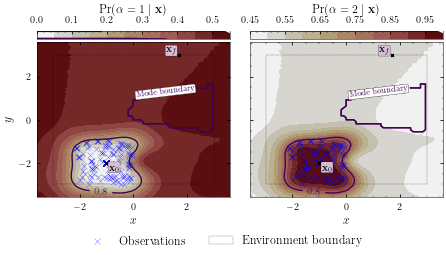

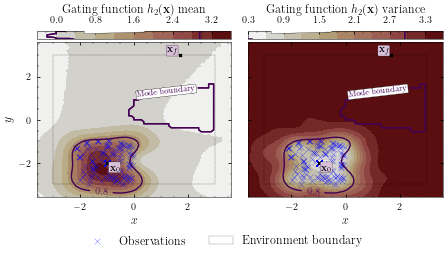

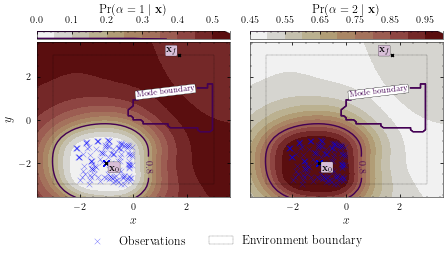

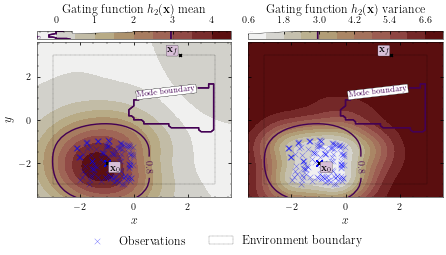

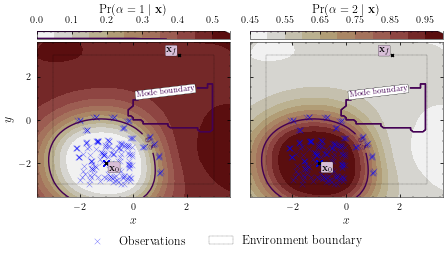

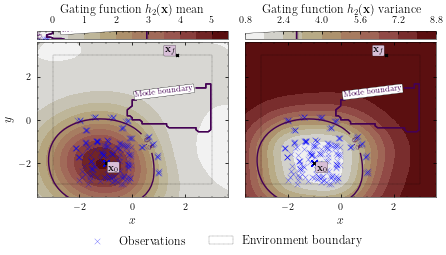

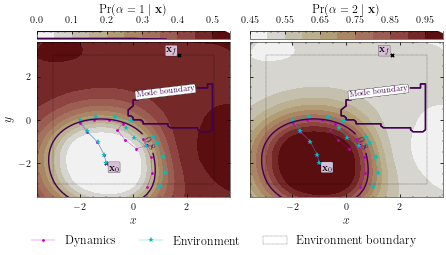

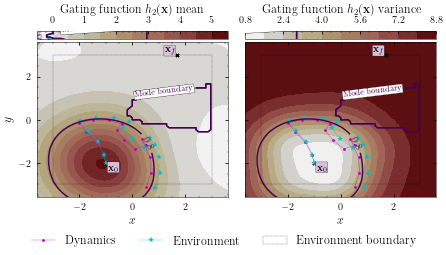

Epoch 1/10000
2/3 [===================>..........] - ETA: 0s - loss: -752.9560

2022-04-13 21:10:06.118610: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-13 21:10:06.118628: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


3/3 [==============================] - 2s 964ms/step - loss: -756.5765 - val_loss: -520.0334


2022-04-13 21:10:07.458000: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-13 21:10:07.466721: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-13 21:10:07.472668: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_10_07

2022-04-13 21:10:07.477348: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_10_07/dr-robots-mbp.local.trace.json.gz
2022-04-13 21:10:07.494359: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_10_07

2022-04-13 21:10:07.494542: I tensorflow/core/profiler/rpc/client/s

INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-13-21-01/ckpts/step_2_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
3/3 [==============================] - 0s 18ms/step - loss: -616.9280 - val_loss: -536.6047
Epoch 3/10000
3/3 [==============================] - 0s 18ms/step - loss: -649.5744 - val_loss: -128.9250
Epoch 4/10000
3/3 [==============================] - 0s 18ms/step - loss: -590.0520 - val_loss: -377.9614
Epoch 5/10000
3/3 [==============================] - 0s 17ms/step - loss: -613.6416 - val_loss: -495.1742
Epoch 6/10000
3/3 [==============================] - 0s 17ms/step - loss: -585.8826 - val_loss: -336.1821
Epoch 7/10000
3/3 [==============================] - 0s 18ms/step - loss: -673.6773 - val_loss: -578.7162
Epoch 8/10000
3/3 [==============================] - 0s 18ms/step - loss: -129.0811 - val_loss: -466.4448
Epoch 9/10000
3/3 [==============================] - 0s 17ms/step - loss: -416.0939 - val_loss: -274.0792
Epoch 10/10000
3/3 [==============================] - 0s 17ms/step - loss: -632.5945 - val_loss: -61.7515
Epoch 11/10000
3/3 [==========================

3/3 [==============================] - 0s 16ms/step - loss: -700.5963 - val_loss: -614.3383
Epoch 77/10000
3/3 [==============================] - 0s 17ms/step - loss: -759.8697 - val_loss: -414.3522
Epoch 78/10000
3/3 [==============================] - 0s 17ms/step - loss: -792.6332 - val_loss: -676.8036
Epoch 79/10000
3/3 [==============================] - 0s 17ms/step - loss: -648.1969 - val_loss: -698.0210
Epoch 80/10000
3/3 [==============================] - 0s 16ms/step - loss: -724.3204 - val_loss: -532.1128
Epoch 81/10000
3/3 [==============================] - 0s 17ms/step - loss: -724.7077 - val_loss: -237.2116
Epoch 82/10000
3/3 [==============================] - 0s 17ms/step - loss: -676.0932 - val_loss: -668.7715
Epoch 83/10000
3/3 [==============================] - 0s 17ms/step - loss: -722.2675 - val_loss: -531.1634
Epoch 84/10000
3/3 [==============================] - 0s 17ms/step - loss: -702.8396 - val_loss: -621.5211
Epoch 85/10000
3/3 [==============================] 

3/3 [==============================] - 0s 23ms/step - loss: -711.9490 - val_loss: -549.5164
Epoch 153/10000
3/3 [==============================] - 0s 22ms/step - loss: -701.0914 - val_loss: -221.5473
Epoch 154/10000
3/3 [==============================] - 0s 22ms/step - loss: -711.5537 - val_loss: -537.7573
Epoch 155/10000
3/3 [==============================] - 0s 21ms/step - loss: -737.0084 - val_loss: -585.7206
Epoch 156/10000
3/3 [==============================] - 0s 22ms/step - loss: -734.3651 - val_loss: -611.6438
Epoch 157/10000
3/3 [==============================] - 0s 22ms/step - loss: -720.7490 - val_loss: -459.2359
Epoch 158/10000
3/3 [==============================] - 0s 23ms/step - loss: -704.9019 - val_loss: -606.5432
Epoch 159/10000
3/3 [==============================] - 0s 22ms/step - loss: -728.2709 - val_loss: -595.2890
Epoch 160/10000
3/3 [==============================] - 0s 23ms/step - loss: -733.6624 - val_loss: -643.5539
Epoch 161/10000
3/3 [=======================

3/3 [==============================] - 0s 23ms/step - loss: -799.6699 - val_loss: -527.3936
Epoch 229/10000
3/3 [==============================] - 0s 21ms/step - loss: -716.7513 - val_loss: -735.3410
Epoch 230/10000
3/3 [==============================] - 0s 21ms/step - loss: -781.6089 - val_loss: -168.9292
Epoch 231/10000
3/3 [==============================] - 0s 21ms/step - loss: -682.7776 - val_loss: -647.4603
Epoch 232/10000
3/3 [==============================] - 0s 21ms/step - loss: -636.9007 - val_loss: -663.5672
Epoch 233/10000
3/3 [==============================] - 0s 21ms/step - loss: -448.8371 - val_loss: -625.7375
Epoch 234/10000
3/3 [==============================] - 0s 21ms/step - loss: -671.6056 - val_loss: -687.6147
Epoch 235/10000
3/3 [==============================] - 0s 21ms/step - loss: -643.6756 - val_loss: -495.7333
Epoch 236/10000
3/3 [==============================] - 0s 21ms/step - loss: -796.6406 - val_loss: -430.6689
Epoch 237/10000
3/3 [=======================

3/3 [==============================] - 0s 28ms/step - loss: -730.6777 - val_loss: -709.2784
Epoch 305/10000
3/3 [==============================] - 0s 28ms/step - loss: -763.0885 - val_loss: -581.2680
Epoch 306/10000
3/3 [==============================] - 0s 25ms/step - loss: -743.8649 - val_loss: -585.7184
Epoch 307/10000
3/3 [==============================] - 0s 25ms/step - loss: -711.3540 - val_loss: -691.5968
Epoch 308/10000
3/3 [==============================] - 0s 25ms/step - loss: -733.7194 - val_loss: -531.3203
Epoch 309/10000
3/3 [==============================] - 0s 26ms/step - loss: -546.5433 - val_loss: -704.5317
Epoch 310/10000
3/3 [==============================] - 0s 25ms/step - loss: -674.7782 - val_loss: -530.0475
Epoch 311/10000
3/3 [==============================] - 0s 24ms/step - loss: -596.9805 - val_loss: -334.1764
Epoch 312/10000
3/3 [==============================] - 0s 24ms/step - loss: -431.7628 - val_loss: -553.2810
Epoch 313/10000
3/3 [=======================

3/3 [==============================] - 0s 24ms/step - loss: -732.4425 - val_loss: -655.2680
Epoch 381/10000
3/3 [==============================] - 0s 25ms/step - loss: -753.8341 - val_loss: -549.8974
Epoch 382/10000
3/3 [==============================] - 0s 25ms/step - loss: -620.0147 - val_loss: -736.4917
Epoch 383/10000
3/3 [==============================] - 0s 24ms/step - loss: -711.1825 - val_loss: -695.1818
Epoch 384/10000
3/3 [==============================] - 0s 25ms/step - loss: -777.3691 - val_loss: -672.8672
Epoch 385/10000
3/3 [==============================] - 0s 24ms/step - loss: -606.7532 - val_loss: -630.1129
Epoch 386/10000
3/3 [==============================] - 0s 26ms/step - loss: -732.3420 - val_loss: -537.6505
Epoch 387/10000
3/3 [==============================] - 0s 25ms/step - loss: -702.3625 - val_loss: -559.2861
Epoch 388/10000
3/3 [==============================] - 0s 24ms/step - loss: -762.4979 - val_loss: -436.5022
Epoch 389/10000
3/3 [=======================

3/3 [==============================] - 0s 24ms/step - loss: -800.7912 - val_loss: -619.6664
Epoch 457/10000
3/3 [==============================] - 0s 23ms/step - loss: -708.1647 - val_loss: -655.5997
Epoch 458/10000
3/3 [==============================] - 0s 24ms/step - loss: -740.6170 - val_loss: -665.5593
Epoch 459/10000
3/3 [==============================] - 0s 25ms/step - loss: -690.9147 - val_loss: -627.7620
Epoch 460/10000
3/3 [==============================] - 0s 23ms/step - loss: -515.7627 - val_loss: -489.3592
Epoch 461/10000
3/3 [==============================] - 0s 23ms/step - loss: -670.1032 - val_loss: -524.6234
Epoch 462/10000
3/3 [==============================] - 0s 23ms/step - loss: -761.8389 - val_loss: -463.2337
Epoch 463/10000
3/3 [==============================] - 0s 23ms/step - loss: -556.3506 - val_loss: 315.7975
Epoch 464/10000
3/3 [==============================] - 0s 23ms/step - loss: -273.5524 - val_loss: -505.2713
Epoch 465/10000
3/3 [========================

3/3 [==============================] - 0s 23ms/step - loss: -715.6576 - val_loss: -86.8476
Epoch 533/10000
3/3 [==============================] - 0s 24ms/step - loss: 149.9559 - val_loss: -454.7363
Epoch 534/10000
3/3 [==============================] - 0s 24ms/step - loss: 403.7444 - val_loss: -499.0016
Epoch 535/10000
3/3 [==============================] - 0s 23ms/step - loss: -231.9590 - val_loss: -320.8718
Epoch 536/10000
3/3 [==============================] - 0s 25ms/step - loss: -591.0525 - val_loss: -630.3772
Epoch 537/10000
3/3 [==============================] - 0s 25ms/step - loss: -401.6613 - val_loss: -579.0288
Epoch 538/10000
3/3 [==============================] - 0s 23ms/step - loss: -317.3745 - val_loss: -510.8241
Epoch 539/10000
3/3 [==============================] - 0s 24ms/step - loss: -489.1946 - val_loss: -505.4847
Epoch 540/10000
3/3 [==============================] - 0s 25ms/step - loss: -519.5363 - val_loss: -496.0923
Epoch 541/10000
3/3 [==========================

3/3 [==============================] - 0s 23ms/step - loss: -680.4985 - val_loss: -562.6876
Epoch 609/10000
3/3 [==============================] - 0s 23ms/step - loss: -726.7817 - val_loss: -593.1014
Epoch 610/10000
3/3 [==============================] - 0s 26ms/step - loss: -681.8898 - val_loss: -601.2122
Epoch 611/10000
3/3 [==============================] - 0s 26ms/step - loss: -632.7611 - val_loss: -649.9883
Epoch 612/10000
3/3 [==============================] - 0s 59ms/step - loss: -676.1975 - val_loss: -676.9362
Epoch 613/10000
3/3 [==============================] - 0s 28ms/step - loss: -678.0163 - val_loss: -554.9129
Epoch 614/10000
3/3 [==============================] - 0s 38ms/step - loss: -738.7769 - val_loss: -45.0199
Epoch 615/10000
3/3 [==============================] - 0s 28ms/step - loss: -768.9347 - val_loss: -698.3634
Epoch 616/10000
3/3 [==============================] - 0s 25ms/step - loss: -729.9381 - val_loss: -409.1738
Epoch 617/10000
3/3 [========================

3/3 [==============================] - 0s 23ms/step - loss: -766.2141 - val_loss: -636.3886
Epoch 685/10000
3/3 [==============================] - 0s 23ms/step - loss: -767.7525 - val_loss: -446.1674
Epoch 686/10000
3/3 [==============================] - 0s 22ms/step - loss: -804.7572 - val_loss: -689.2438
Epoch 687/10000
3/3 [==============================] - 0s 23ms/step - loss: -733.3971 - val_loss: -661.2820
Epoch 688/10000
3/3 [==============================] - 0s 23ms/step - loss: -758.7158 - val_loss: -652.2779
Epoch 689/10000
3/3 [==============================] - 0s 23ms/step - loss: -796.9837 - val_loss: -685.6481
Epoch 690/10000
3/3 [==============================] - 0s 22ms/step - loss: -792.0752 - val_loss: -709.9507
Epoch 691/10000
3/3 [==============================] - 0s 23ms/step - loss: -754.2585 - val_loss: -653.3073
Epoch 692/10000
3/3 [==============================] - 0s 22ms/step - loss: -786.1940 - val_loss: -652.8479
Epoch 693/10000
3/3 [=======================

3/3 [==============================] - 0s 24ms/step - loss: -776.2413 - val_loss: -684.7934
Epoch 761/10000
3/3 [==============================] - 0s 24ms/step - loss: -784.7273 - val_loss: -596.5518
Epoch 762/10000
3/3 [==============================] - 0s 24ms/step - loss: -782.0317 - val_loss: -676.8919
Epoch 763/10000
3/3 [==============================] - 0s 24ms/step - loss: -762.7419 - val_loss: -533.0549
Epoch 764/10000
3/3 [==============================] - 0s 25ms/step - loss: -762.0996 - val_loss: -580.0729
Epoch 765/10000
3/3 [==============================] - 0s 25ms/step - loss: -784.8511 - val_loss: -674.4361
Epoch 766/10000
3/3 [==============================] - 0s 24ms/step - loss: -794.6785 - val_loss: -701.9221
Epoch 767/10000
3/3 [==============================] - 0s 24ms/step - loss: -790.8321 - val_loss: -600.5441
Epoch 768/10000
3/3 [==============================] - 0s 24ms/step - loss: -760.9457 - val_loss: -742.8093
Epoch 769/10000
3/3 [=======================

3/3 [==============================] - 0s 24ms/step - loss: -829.9454 - val_loss: -675.5216
Epoch 837/10000
3/3 [==============================] - 0s 24ms/step - loss: -829.4672 - val_loss: -660.1294
Epoch 838/10000
3/3 [==============================] - 0s 24ms/step - loss: -821.3603 - val_loss: -634.7322
Epoch 839/10000
3/3 [==============================] - 0s 24ms/step - loss: -754.0512 - val_loss: -670.8210
Epoch 840/10000
3/3 [==============================] - 0s 24ms/step - loss: -655.1078 - val_loss: -756.7745
Epoch 841/10000
3/3 [==============================] - 0s 24ms/step - loss: -724.1555 - val_loss: -689.9191
Epoch 842/10000
3/3 [==============================] - 0s 25ms/step - loss: -589.8631 - val_loss: -246.7476
Epoch 843/10000
3/3 [==============================] - 0s 25ms/step - loss: -606.4223 - val_loss: -670.8319
Epoch 844/10000
3/3 [==============================] - 0s 24ms/step - loss: -703.0176 - val_loss: -701.8655
Epoch 845/10000
3/3 [=======================

3/3 [==============================] - 0s 23ms/step - loss: -818.2512 - val_loss: -729.7415
Epoch 913/10000
3/3 [==============================] - 0s 22ms/step - loss: -648.6208 - val_loss: -757.5475
Epoch 914/10000
3/3 [==============================] - 0s 23ms/step - loss: -758.7481 - val_loss: -99.9104
Epoch 915/10000
3/3 [==============================] - 0s 22ms/step - loss: -752.5437 - val_loss: -660.8219
Epoch 916/10000
3/3 [==============================] - 0s 23ms/step - loss: -753.2673 - val_loss: -679.4826
Epoch 917/10000
3/3 [==============================] - 0s 23ms/step - loss: -456.8185 - val_loss: -574.8748
Epoch 918/10000
3/3 [==============================] - 0s 22ms/step - loss: -659.1789 - val_loss: -184.7232
Epoch 919/10000
3/3 [==============================] - 0s 22ms/step - loss: -595.3342 - val_loss: -487.1120
Epoch 920/10000
3/3 [==============================] - 0s 23ms/step - loss: -747.3634 - val_loss: -525.3893
Epoch 921/10000
3/3 [========================

3/3 [==============================] - 0s 24ms/step - loss: -795.5990 - val_loss: -691.1623
Epoch 989/10000
3/3 [==============================] - 0s 24ms/step - loss: -742.5099 - val_loss: -686.2209
Epoch 990/10000
3/3 [==============================] - 0s 23ms/step - loss: -777.4785 - val_loss: -701.8487
Epoch 991/10000
3/3 [==============================] - 0s 23ms/step - loss: -759.8092 - val_loss: -659.4120
Epoch 992/10000
3/3 [==============================] - 0s 24ms/step - loss: -677.6565 - val_loss: -581.2580
Epoch 993/10000
3/3 [==============================] - 0s 23ms/step - loss: -741.2626 - val_loss: -682.3106
Epoch 994/10000
3/3 [==============================] - 0s 23ms/step - loss: -606.3533 - val_loss: -523.8650
Epoch 995/10000
3/3 [==============================] - 0s 23ms/step - loss: -694.8647 - val_loss: -438.8227
Epoch 996/10000
3/3 [==============================] - 0s 25ms/step - loss: -580.5386 - val_loss: -680.5388
Epoch 997/10000
3/3 [=======================

3/3 [==============================] - 0s 23ms/step - loss: -573.1813 - val_loss: -554.7342
Epoch 1064/10000
3/3 [==============================] - 0s 24ms/step - loss: -688.5362 - val_loss: -587.8947
Epoch 1065/10000
3/3 [==============================] - 0s 24ms/step - loss: -710.1865 - val_loss: -718.7550
Epoch 1066/10000
3/3 [==============================] - 0s 23ms/step - loss: -706.7846 - val_loss: -603.0499
Epoch 1067/10000
3/3 [==============================] - 0s 23ms/step - loss: -524.4108 - val_loss: -660.4445
Epoch 1068/10000
3/3 [==============================] - 0s 23ms/step - loss: -337.6680 - val_loss: -465.3151
Epoch 1069/10000
3/3 [==============================] - 0s 24ms/step - loss: -107.3118 - val_loss: -628.3825
Epoch 1070/10000
3/3 [==============================] - 0s 24ms/step - loss: -752.6595 - val_loss: -652.2958
Epoch 1071/10000
3/3 [==============================] - 0s 24ms/step - loss: -669.4134 - val_loss: -647.0224
Epoch 1072/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -648.9857 - val_loss: -633.5203
Epoch 1139/10000
3/3 [==============================] - 0s 23ms/step - loss: -685.8897 - val_loss: -607.6188
Epoch 1140/10000
3/3 [==============================] - 0s 23ms/step - loss: -768.1830 - val_loss: -698.0156
Epoch 1141/10000
3/3 [==============================] - 0s 22ms/step - loss: -636.8936 - val_loss: -317.4518
Epoch 1142/10000
3/3 [==============================] - 0s 23ms/step - loss: -662.8023 - val_loss: -653.9811
Epoch 1143/10000
3/3 [==============================] - 0s 23ms/step - loss: -740.2733 - val_loss: -566.1975
Epoch 1144/10000
3/3 [==============================] - 0s 23ms/step - loss: -657.8511 - val_loss: -613.2224
Epoch 1145/10000
3/3 [==============================] - 0s 23ms/step - loss: -735.8281 - val_loss: -661.3170
Epoch 1146/10000
3/3 [==============================] - 0s 23ms/step - loss: -755.1956 - val_loss: -657.0006
Epoch 1147/10000
3/3 [==============

3/3 [==============================] - 0s 25ms/step - loss: -828.7094 - val_loss: -696.5221
Epoch 1214/10000
3/3 [==============================] - 0s 25ms/step - loss: -827.9781 - val_loss: -723.5578
Epoch 1215/10000
3/3 [==============================] - 0s 24ms/step - loss: -841.4838 - val_loss: -723.6524
Epoch 1216/10000
3/3 [==============================] - 0s 24ms/step - loss: -835.1843 - val_loss: -685.7337
Epoch 1217/10000
3/3 [==============================] - 0s 25ms/step - loss: -842.3051 - val_loss: -705.9260
Epoch 1218/10000
3/3 [==============================] - 0s 25ms/step - loss: -854.9912 - val_loss: -673.1890
Epoch 1219/10000
3/3 [==============================] - 0s 24ms/step - loss: -860.1337 - val_loss: -707.2321
Epoch 1220/10000
3/3 [==============================] - 0s 25ms/step - loss: -810.6425 - val_loss: -713.3889
Epoch 1221/10000
3/3 [==============================] - 0s 26ms/step - loss: -813.5672 - val_loss: -741.1269
Epoch 1222/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -701.9897 - val_loss: -536.6626
Epoch 1289/10000
3/3 [==============================] - 0s 23ms/step - loss: -709.2778 - val_loss: -578.8637
Epoch 1290/10000
3/3 [==============================] - 0s 24ms/step - loss: -648.6283 - val_loss: -577.7549
Epoch 1291/10000
3/3 [==============================] - 0s 25ms/step - loss: -705.7701 - val_loss: -580.1542
Epoch 1292/10000
3/3 [==============================] - 0s 23ms/step - loss: -630.3691 - val_loss: -550.2683
Epoch 1293/10000
3/3 [==============================] - 0s 23ms/step - loss: -727.4565 - val_loss: -656.0832
Epoch 1294/10000
3/3 [==============================] - 0s 23ms/step - loss: -667.0610 - val_loss: -609.0126
Epoch 1295/10000
3/3 [==============================] - 0s 26ms/step - loss: -738.7113 - val_loss: -636.9146
Epoch 1296/10000
3/3 [==============================] - 0s 24ms/step - loss: -683.7881 - val_loss: -592.6440
Epoch 1297/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -758.8788 - val_loss: -728.7134
Epoch 1364/10000
3/3 [==============================] - 0s 23ms/step - loss: -856.0156 - val_loss: -590.2636
Epoch 1365/10000
3/3 [==============================] - 0s 23ms/step - loss: -743.9694 - val_loss: -728.0575
Epoch 1366/10000
3/3 [==============================] - 0s 23ms/step - loss: -692.3156 - val_loss: -745.0273
Epoch 1367/10000
3/3 [==============================] - 0s 22ms/step - loss: -857.3280 - val_loss: -501.7179
Epoch 1368/10000
3/3 [==============================] - 0s 23ms/step - loss: -693.2860 - val_loss: -689.1708
Epoch 1369/10000
3/3 [==============================] - 0s 23ms/step - loss: -748.6297 - val_loss: -677.9116
Epoch 1370/10000
3/3 [==============================] - 0s 23ms/step - loss: -822.5618 - val_loss: -731.8558
Epoch 1371/10000
3/3 [==============================] - 0s 22ms/step - loss: -761.5656 - val_loss: -665.9521
Epoch 1372/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -590.5876 - val_loss: -746.5886
Epoch 1439/10000
3/3 [==============================] - 0s 23ms/step - loss: -789.0029 - val_loss: -734.6559
Epoch 1440/10000
3/3 [==============================] - 0s 23ms/step - loss: -847.1789 - val_loss: -735.4944
Epoch 1441/10000
3/3 [==============================] - 0s 22ms/step - loss: -654.6885 - val_loss: -713.6357
Epoch 1442/10000
3/3 [==============================] - 0s 22ms/step - loss: -670.5224 - val_loss: -230.7692
Epoch 1443/10000
3/3 [==============================] - 0s 22ms/step - loss: -771.9989 - val_loss: -628.9559
Epoch 1444/10000
3/3 [==============================] - 0s 22ms/step - loss: -607.6299 - val_loss: -649.8591
Epoch 1445/10000
3/3 [==============================] - 0s 23ms/step - loss: -784.1324 - val_loss: -651.0039
Epoch 1446/10000
3/3 [==============================] - 0s 22ms/step - loss: -584.7825 - val_loss: -677.2396
Epoch 1447/10000
3/3 [==============

3/3 [==============================] - 0s 21ms/step - loss: -787.0846 - val_loss: -472.6160
Epoch 1514/10000
3/3 [==============================] - 0s 21ms/step - loss: -646.0941 - val_loss: -634.1737
Epoch 1515/10000
3/3 [==============================] - 0s 21ms/step - loss: -787.5762 - val_loss: -560.9998
Epoch 1516/10000
3/3 [==============================] - 0s 21ms/step - loss: -764.5293 - val_loss: -377.9318
Epoch 1517/10000
3/3 [==============================] - 0s 21ms/step - loss: -772.4675 - val_loss: -617.2600
Epoch 1518/10000
3/3 [==============================] - 0s 21ms/step - loss: -557.9541 - val_loss: -627.5293
Epoch 1519/10000
3/3 [==============================] - 0s 21ms/step - loss: -782.2263 - val_loss: -676.2510
Epoch 1520/10000
3/3 [==============================] - 0s 22ms/step - loss: -817.1327 - val_loss: -641.5947
Epoch 1521/10000
3/3 [==============================] - 0s 22ms/step - loss: -607.5914 - val_loss: -702.5827
Epoch 1522/10000
3/3 [==============

3/3 [==============================] - 0s 21ms/step - loss: -746.2009 - val_loss: -595.3480
Epoch 1589/10000
3/3 [==============================] - 0s 21ms/step - loss: -595.5188 - val_loss: -703.9349
Epoch 1590/10000
3/3 [==============================] - 0s 21ms/step - loss: -828.1052 - val_loss: -753.7490
Epoch 1591/10000
3/3 [==============================] - 0s 21ms/step - loss: -869.6728 - val_loss: -681.2831
Epoch 1592/10000
3/3 [==============================] - 0s 21ms/step - loss: -805.7930 - val_loss: -647.7161
Epoch 1593/10000
3/3 [==============================] - 0s 21ms/step - loss: -495.4031 - val_loss: -660.5678
Epoch 1594/10000
3/3 [==============================] - 0s 22ms/step - loss: -682.1560 - val_loss: -713.5808
Epoch 1595/10000
3/3 [==============================] - 0s 22ms/step - loss: -762.5237 - val_loss: -519.7444
Epoch 1596/10000
3/3 [==============================] - 0s 22ms/step - loss: -520.7138 - val_loss: -679.1646
Epoch 1597/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -883.7841 - val_loss: -730.5408
Epoch 1664/10000
3/3 [==============================] - 0s 22ms/step - loss: -873.4193 - val_loss: -707.6220
Epoch 1665/10000
3/3 [==============================] - 0s 22ms/step - loss: -871.2927 - val_loss: -742.4927
Epoch 1666/10000
3/3 [==============================] - 0s 22ms/step - loss: -886.9749 - val_loss: -721.7067
Epoch 1667/10000
3/3 [==============================] - 0s 21ms/step - loss: -873.1305 - val_loss: -773.8766
Epoch 1668/10000
3/3 [==============================] - 0s 24ms/step - loss: -869.9267 - val_loss: -768.5632
Epoch 1669/10000
3/3 [==============================] - 0s 23ms/step - loss: -865.4866 - val_loss: -634.2989
Epoch 1670/10000
3/3 [==============================] - 0s 21ms/step - loss: -870.5000 - val_loss: -754.3314
Epoch 1671/10000
3/3 [==============================] - 0s 21ms/step - loss: -879.5851 - val_loss: -677.4865
Epoch 1672/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -662.7061 - val_loss: -538.0689
Epoch 1739/10000
3/3 [==============================] - 0s 20ms/step - loss: -571.8419 - val_loss: -619.8389
Epoch 1740/10000
3/3 [==============================] - 0s 21ms/step - loss: -689.0431 - val_loss: -627.7399
Epoch 1741/10000
3/3 [==============================] - 0s 21ms/step - loss: -764.2962 - val_loss: -649.1101
Epoch 1742/10000
3/3 [==============================] - 0s 21ms/step - loss: -630.0241 - val_loss: -513.6781
Epoch 1743/10000
3/3 [==============================] - 0s 21ms/step - loss: -651.7106 - val_loss: -682.3870
Epoch 1744/10000
3/3 [==============================] - 0s 21ms/step - loss: -672.7410 - val_loss: -678.1103
Epoch 1745/10000
3/3 [==============================] - 0s 21ms/step - loss: -626.8959 - val_loss: -639.2017
Epoch 1746/10000
3/3 [==============================] - 0s 21ms/step - loss: -746.4265 - val_loss: -615.9238
Epoch 1747/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: -697.6739 - val_loss: -589.9719
Epoch 1814/10000
3/3 [==============================] - 0s 22ms/step - loss: -673.4326 - val_loss: -598.4920
Epoch 1815/10000
3/3 [==============================] - 0s 22ms/step - loss: -701.4128 - val_loss: -541.1841
Epoch 1816/10000
3/3 [==============================] - 0s 22ms/step - loss: -739.5386 - val_loss: -553.4874
Epoch 1817/10000
3/3 [==============================] - 0s 22ms/step - loss: -759.9840 - val_loss: -629.7296
Epoch 1818/10000
3/3 [==============================] - 0s 22ms/step - loss: -759.1721 - val_loss: -598.8045
Epoch 1819/10000
3/3 [==============================] - 0s 22ms/step - loss: -776.7509 - val_loss: -641.4853
Epoch 1820/10000
3/3 [==============================] - 0s 22ms/step - loss: -736.0898 - val_loss: -638.5354
Epoch 1821/10000
3/3 [==============================] - 0s 22ms/step - loss: -780.6391 - val_loss: -623.6819
Epoch 1822/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -684.3299 - val_loss: -713.1021
Epoch 1889/10000
3/3 [==============================] - 0s 22ms/step - loss: -627.4498 - val_loss: -661.4985
Epoch 1890/10000
3/3 [==============================] - 0s 22ms/step - loss: -756.3070 - val_loss: -624.0319
Epoch 1891/10000
3/3 [==============================] - 0s 22ms/step - loss: -699.3795 - val_loss: -508.9346
Epoch 1892/10000
3/3 [==============================] - 0s 22ms/step - loss: -760.0200 - val_loss: -650.1960
Epoch 1893/10000
3/3 [==============================] - 0s 22ms/step - loss: -629.6898 - val_loss: -661.7098
Epoch 1894/10000
3/3 [==============================] - 0s 22ms/step - loss: -787.2462 - val_loss: -658.3646
Epoch 1895/10000
3/3 [==============================] - 0s 21ms/step - loss: -773.5794 - val_loss: -639.7785
Epoch 1896/10000
3/3 [==============================] - 0s 22ms/step - loss: -691.2016 - val_loss: -657.5224
Epoch 1897/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -715.3721 - val_loss: -680.0380
Epoch 1964/10000
3/3 [==============================] - 0s 21ms/step - loss: -759.4196 - val_loss: -675.3334
Epoch 1965/10000
3/3 [==============================] - 0s 22ms/step - loss: -824.2535 - val_loss: -692.5963
Epoch 1966/10000
3/3 [==============================] - 0s 22ms/step - loss: -842.9337 - val_loss: -725.8483
Epoch 1967/10000
3/3 [==============================] - 0s 21ms/step - loss: -686.0776 - val_loss: -636.9769
Epoch 1968/10000
3/3 [==============================] - 0s 22ms/step - loss: -833.8923 - val_loss: -635.9365
Epoch 1969/10000
3/3 [==============================] - 0s 22ms/step - loss: -591.6604 - val_loss: -643.8395
Epoch 1970/10000
3/3 [==============================] - 0s 22ms/step - loss: -774.1498 - val_loss: -723.0714
Epoch 1971/10000
3/3 [==============================] - 0s 22ms/step - loss: -831.0036 - val_loss: -630.3523
Epoch 1972/10000
3/3 [==============

/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2002/10000
3/3 [==============================] - 0s 18ms/step - loss: -357.7701 - val_loss: -635.1392
Epoch 2003/10000
3/3 [==============================] - 0s 18ms/step - loss: -724.9451 - val_loss: -655.0363
Epoch 2004/10000
3/3 [==============================] - 0s 18ms/step - loss: -708.7557 - val_loss: -556.2941
Epoch 2005/10000
3/3 [==============================] - 0s 18ms/step - loss: -659.5968 - val_loss: -517.0831
Epoch 2006/10000
3/3 [==============================] - 0s 17ms/step - loss: 341.6063 - val_loss: -580.0710
Epoch 2007/10000
3/3 [==============================] - 0s 18ms/step - loss: -492.2579 - val_loss: -437.3370
Epoch 2008/10000
3/3 [==============================] - 0s 18ms/step - loss: -581.3566 - val_loss: -465.3905
Epoch 2009/10000
3/3 [==============================] - 0s 18ms/step - loss: -436.3857 - val_loss: -485.9037
Epoch 2010/10000
3/3 [==============================] - 0s 18ms/step - loss: -375.1537 - val_loss: -543.9686
Epoch 2011/10000
3/3

3/3 [==============================] - 0s 25ms/step - loss: -670.1923 - val_loss: -609.7559
Epoch 2078/10000
3/3 [==============================] - 0s 22ms/step - loss: -471.9880 - val_loss: -601.2367
Epoch 2079/10000
3/3 [==============================] - 0s 22ms/step - loss: -481.4207 - val_loss: -359.1137
Epoch 2080/10000
3/3 [==============================] - 0s 23ms/step - loss: -415.2467 - val_loss: -625.3882
Epoch 2081/10000
3/3 [==============================] - 0s 22ms/step - loss: -379.2297 - val_loss: -174.1284
Epoch 2082/10000
3/3 [==============================] - 0s 23ms/step - loss: -503.0004 - val_loss: -409.0841
Epoch 2083/10000
3/3 [==============================] - 0s 21ms/step - loss: -480.4350 - val_loss: -523.3836
Epoch 2084/10000
3/3 [==============================] - 0s 22ms/step - loss: -388.8701 - val_loss: -431.6584
Epoch 2085/10000
3/3 [==============================] - 0s 22ms/step - loss: -596.0005 - val_loss: -29.6246
Epoch 2086/10000
3/3 [===============

3/3 [==============================] - 0s 20ms/step - loss: -654.0919 - val_loss: -563.1257
Epoch 2153/10000
3/3 [==============================] - 0s 20ms/step - loss: -596.6352 - val_loss: -505.0456
Epoch 2154/10000
3/3 [==============================] - 0s 20ms/step - loss: -499.0748 - val_loss: -247.1332
Epoch 2155/10000
3/3 [==============================] - 0s 20ms/step - loss: -658.8568 - val_loss: -225.4222
Epoch 2156/10000
3/3 [==============================] - 0s 20ms/step - loss: -564.2951 - val_loss: -554.1538
Epoch 2157/10000
3/3 [==============================] - 0s 21ms/step - loss: -478.0425 - val_loss: -342.4836
Epoch 2158/10000
3/3 [==============================] - 0s 21ms/step - loss: -518.1586 - val_loss: -536.1482
Epoch 2159/10000
3/3 [==============================] - 0s 21ms/step - loss: -660.1987 - val_loss: -615.8160
Epoch 2160/10000
3/3 [==============================] - 0s 21ms/step - loss: -507.8454 - val_loss: -583.1365
Epoch 2161/10000
3/3 [==============

3/3 [==============================] - 0s 20ms/step - loss: -405.6522 - val_loss: -513.5561
Epoch 2228/10000
3/3 [==============================] - 0s 21ms/step - loss: -129.5235 - val_loss: -188.4430
Epoch 2229/10000
3/3 [==============================] - 0s 21ms/step - loss: -479.2936 - val_loss: -408.1458
Epoch 2230/10000
3/3 [==============================] - 0s 20ms/step - loss: -342.4801 - val_loss: -276.9066
Epoch 2231/10000
3/3 [==============================] - 0s 20ms/step - loss: -567.1124 - val_loss: -464.4063
Epoch 2232/10000
3/3 [==============================] - 0s 20ms/step - loss: -505.9777 - val_loss: -292.1868
Epoch 2233/10000
3/3 [==============================] - 0s 20ms/step - loss: -581.8960 - val_loss: -610.7966
Epoch 2234/10000
3/3 [==============================] - 0s 20ms/step - loss: -590.6250 - val_loss: -241.2393
Epoch 2235/10000
3/3 [==============================] - 0s 20ms/step - loss: -650.5055 - val_loss: -572.3929
Epoch 2236/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -718.3702 - val_loss: -562.5979
Epoch 2303/10000
3/3 [==============================] - 0s 23ms/step - loss: -697.7314 - val_loss: -208.0888
Epoch 2304/10000
3/3 [==============================] - 0s 22ms/step - loss: -698.3149 - val_loss: -663.8365
Epoch 2305/10000
3/3 [==============================] - 0s 22ms/step - loss: -569.1571 - val_loss: -385.4704
Epoch 2306/10000
3/3 [==============================] - 0s 23ms/step - loss: -634.5452 - val_loss: -530.1634
Epoch 2307/10000
3/3 [==============================] - 0s 24ms/step - loss: -314.9759 - val_loss: -289.2772
Epoch 2308/10000
3/3 [==============================] - 0s 22ms/step - loss: -595.5208 - val_loss: -161.4467
Epoch 2309/10000
3/3 [==============================] - 0s 23ms/step - loss: -474.6446 - val_loss: -611.0425
Epoch 2310/10000
3/3 [==============================] - 0s 23ms/step - loss: -484.4820 - val_loss: -438.8668
Epoch 2311/10000
3/3 [==============

3/3 [==============================] - 0s 21ms/step - loss: -690.3336 - val_loss: -710.2508
Epoch 2378/10000
3/3 [==============================] - 0s 20ms/step - loss: -660.1355 - val_loss: -498.4217
Epoch 2379/10000
3/3 [==============================] - 0s 21ms/step - loss: -734.7721 - val_loss: -674.6184
Epoch 2380/10000
3/3 [==============================] - 0s 21ms/step - loss: -704.3864 - val_loss: -673.3049
Epoch 2381/10000
3/3 [==============================] - 0s 20ms/step - loss: -695.0137 - val_loss: -591.4402
Epoch 2382/10000
3/3 [==============================] - 0s 20ms/step - loss: -678.3598 - val_loss: -624.6547
Epoch 2383/10000
3/3 [==============================] - 0s 20ms/step - loss: -686.3364 - val_loss: -725.2553
Epoch 2384/10000
3/3 [==============================] - 0s 20ms/step - loss: -769.5288 - val_loss: -658.1842
Epoch 2385/10000
3/3 [==============================] - 0s 21ms/step - loss: -664.6628 - val_loss: -637.7322
Epoch 2386/10000
3/3 [==============

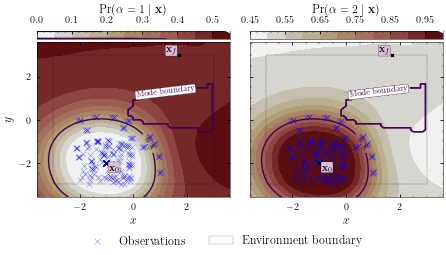

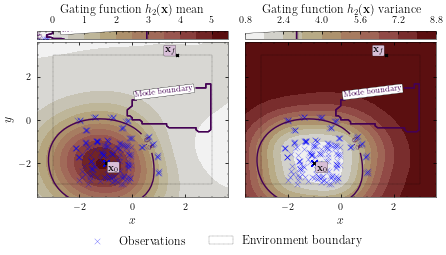

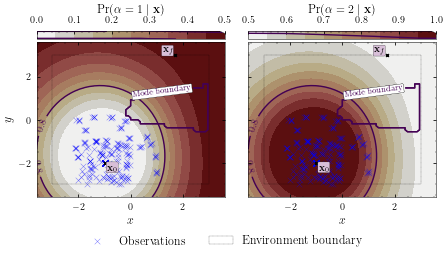

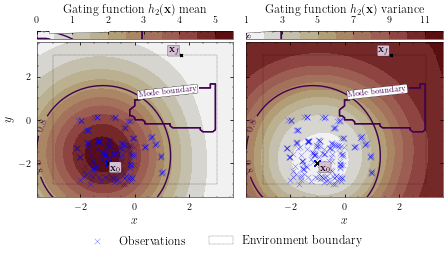

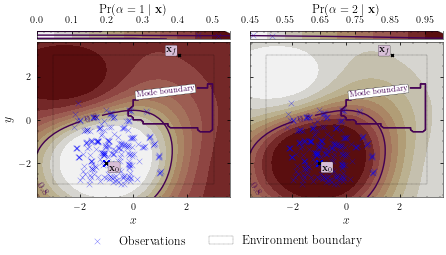

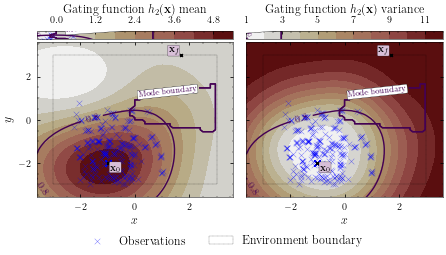

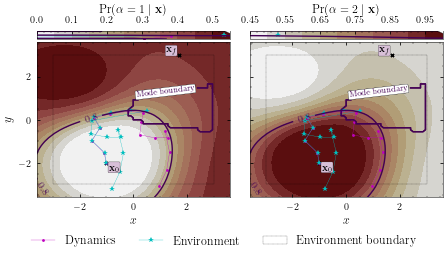

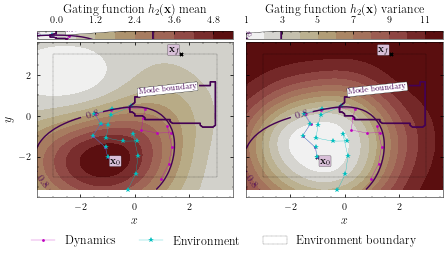

Epoch 1/10000
2/3 [===================>..........] - ETA: 0s - loss: -628.2139

2022-04-13 21:14:41.527683: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-13 21:14:41.527700: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


3/3 [==============================] - 2s 906ms/step - loss: -627.1556 - val_loss: -483.1104


2022-04-13 21:14:42.749441: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-13 21:14:42.757360: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-13 21:14:42.764524: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_14_42

2022-04-13 21:14:42.768967: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_14_42/dr-robots-mbp.local.trace.json.gz
2022-04-13 21:14:42.785443: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_14_42

2022-04-13 21:14:42.786025: I tensorflow/core/profiler/rpc/client/s

INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-13-21-01/ckpts/step_3_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
3/3 [==============================] - 0s 25ms/step - loss: -617.6165 - val_loss: -62.7410
Epoch 3/10000
3/3 [==============================] - 0s 22ms/step - loss: -684.4613 - val_loss: -417.1856
Epoch 4/10000
3/3 [==============================] - 0s 22ms/step - loss: -546.6846 - val_loss: -169.0690
Epoch 5/10000
3/3 [==============================] - 0s 23ms/step - loss: -646.9818 - val_loss: -210.5638
Epoch 6/10000
3/3 [==============================] - 0s 23ms/step - loss: -623.3252 - val_loss: -399.0326
Epoch 7/10000
3/3 [==============================] - 0s 22ms/step - loss: -647.3395 - val_loss: -417.3739
Epoch 8/10000
3/3 [==============================] - 0s 22ms/step - loss: -697.3238 - val_loss: -140.8506
Epoch 9/10000
3/3 [==============================] - 0s 22ms/step - loss: -592.4294 - val_loss: -350.5192
Epoch 10/10000
3/3 [==============================] - 0s 22ms/step - loss: -522.2068 - val_loss: -388.4460
Epoch 11/10000
3/3 [==========================

3/3 [==============================] - 0s 23ms/step - loss: -765.2610 - val_loss: -290.2024
Epoch 77/10000
3/3 [==============================] - 0s 23ms/step - loss: -758.2879 - val_loss: -236.9009
Epoch 78/10000
3/3 [==============================] - 0s 23ms/step - loss: -747.6125 - val_loss: -224.6294
Epoch 79/10000
3/3 [==============================] - 0s 23ms/step - loss: -705.7488 - val_loss: -400.2640
Epoch 80/10000
3/3 [==============================] - 0s 23ms/step - loss: -735.2187 - val_loss: -285.0316
Epoch 81/10000
3/3 [==============================] - 0s 24ms/step - loss: -746.2618 - val_loss: -445.6471
Epoch 82/10000
3/3 [==============================] - 0s 23ms/step - loss: -778.0037 - val_loss: -363.1394
Epoch 83/10000
3/3 [==============================] - 0s 23ms/step - loss: -776.7321 - val_loss: -80.5520
Epoch 84/10000
3/3 [==============================] - 0s 22ms/step - loss: -725.1726 - val_loss: -475.5840
Epoch 85/10000
3/3 [==============================] -

3/3 [==============================] - 0s 25ms/step - loss: -741.5845 - val_loss: -512.5860
Epoch 153/10000
3/3 [==============================] - 0s 26ms/step - loss: -672.2676 - val_loss: -347.8866
Epoch 154/10000
3/3 [==============================] - 0s 25ms/step - loss: -737.6278 - val_loss: -526.2644
Epoch 155/10000
3/3 [==============================] - 0s 28ms/step - loss: -710.6246 - val_loss: -288.3140
Epoch 156/10000
3/3 [==============================] - 0s 23ms/step - loss: -730.9263 - val_loss: -135.5713
Epoch 157/10000
3/3 [==============================] - 0s 25ms/step - loss: -720.1188 - val_loss: -140.7240
Epoch 158/10000
3/3 [==============================] - 0s 24ms/step - loss: -716.9130 - val_loss: -331.4831
Epoch 159/10000
3/3 [==============================] - 0s 24ms/step - loss: -744.2004 - val_loss: -267.4495
Epoch 160/10000
3/3 [==============================] - 0s 24ms/step - loss: -661.8975 - val_loss: -431.3372
Epoch 161/10000
3/3 [=======================

3/3 [==============================] - 0s 28ms/step - loss: -556.5380 - val_loss: -293.2030
Epoch 229/10000
3/3 [==============================] - 0s 29ms/step - loss: -588.0137 - val_loss: -508.0024
Epoch 230/10000
3/3 [==============================] - 0s 28ms/step - loss: -681.9764 - val_loss: -467.6929
Epoch 231/10000
3/3 [==============================] - 0s 26ms/step - loss: -539.7597 - val_loss: -492.8410
Epoch 232/10000
3/3 [==============================] - 0s 26ms/step - loss: -592.0089 - val_loss: -568.6781
Epoch 233/10000
3/3 [==============================] - 0s 28ms/step - loss: -645.6769 - val_loss: -482.1450
Epoch 234/10000
3/3 [==============================] - 0s 27ms/step - loss: -622.7432 - val_loss: -413.1221
Epoch 235/10000
3/3 [==============================] - 0s 26ms/step - loss: -611.3646 - val_loss: -334.6996
Epoch 236/10000
3/3 [==============================] - 0s 26ms/step - loss: -629.8577 - val_loss: -499.4816
Epoch 237/10000
3/3 [=======================

3/3 [==============================] - 0s 27ms/step - loss: -576.1570 - val_loss: -451.1078
Epoch 305/10000
3/3 [==============================] - 0s 28ms/step - loss: -660.2384 - val_loss: -464.2633
Epoch 306/10000
3/3 [==============================] - 0s 27ms/step - loss: -689.2331 - val_loss: -535.4812
Epoch 307/10000
3/3 [==============================] - 0s 27ms/step - loss: -652.9556 - val_loss: -452.3699
Epoch 308/10000
3/3 [==============================] - 0s 27ms/step - loss: -709.3647 - val_loss: -370.9768
Epoch 309/10000
3/3 [==============================] - 0s 27ms/step - loss: -731.0660 - val_loss: -570.4791
Epoch 310/10000
3/3 [==============================] - 0s 29ms/step - loss: -696.9461 - val_loss: -488.5313
Epoch 311/10000
3/3 [==============================] - 0s 29ms/step - loss: -683.9756 - val_loss: -580.7554
Epoch 312/10000
3/3 [==============================] - 0s 27ms/step - loss: -571.7424 - val_loss: -355.4508
Epoch 313/10000
3/3 [=======================

3/3 [==============================] - 0s 26ms/step - loss: -641.9050 - val_loss: -558.0680
Epoch 381/10000
3/3 [==============================] - 0s 26ms/step - loss: -680.4973 - val_loss: -329.5067
Epoch 382/10000
3/3 [==============================] - 0s 27ms/step - loss: -686.2098 - val_loss: -414.2516
Epoch 383/10000
3/3 [==============================] - 0s 30ms/step - loss: -659.1676 - val_loss: -212.1352
Epoch 384/10000
3/3 [==============================] - 0s 30ms/step - loss: -588.5128 - val_loss: -417.5006
Epoch 385/10000
3/3 [==============================] - 0s 30ms/step - loss: -670.0235 - val_loss: -506.9728
Epoch 386/10000
3/3 [==============================] - 0s 30ms/step - loss: -696.6894 - val_loss: -536.3599
Epoch 387/10000
3/3 [==============================] - 0s 27ms/step - loss: -628.7074 - val_loss: -446.1060
Epoch 388/10000
3/3 [==============================] - 0s 26ms/step - loss: -708.1794 - val_loss: -189.8121
Epoch 389/10000
3/3 [=======================

3/3 [==============================] - 0s 29ms/step - loss: -602.8297 - val_loss: -483.1436
Epoch 457/10000
3/3 [==============================] - 0s 28ms/step - loss: -603.2707 - val_loss: -472.9169
Epoch 458/10000
3/3 [==============================] - 0s 28ms/step - loss: -634.5334 - val_loss: -439.2313
Epoch 459/10000
3/3 [==============================] - 0s 29ms/step - loss: -704.2668 - val_loss: -412.8595
Epoch 460/10000
3/3 [==============================] - 0s 30ms/step - loss: -658.9707 - val_loss: -524.1510
Epoch 461/10000
3/3 [==============================] - 0s 28ms/step - loss: -666.5455 - val_loss: -401.6773
Epoch 462/10000
3/3 [==============================] - 0s 32ms/step - loss: -596.8184 - val_loss: -461.6628
Epoch 463/10000
3/3 [==============================] - 0s 29ms/step - loss: -705.6398 - val_loss: -453.2388
Epoch 464/10000
3/3 [==============================] - 0s 28ms/step - loss: -690.7432 - val_loss: -427.2387
Epoch 465/10000
3/3 [=======================

3/3 [==============================] - 0s 29ms/step - loss: -741.9747 - val_loss: -590.0193
Epoch 533/10000
3/3 [==============================] - 0s 28ms/step - loss: -808.6458 - val_loss: -583.5941
Epoch 534/10000
3/3 [==============================] - 0s 29ms/step - loss: -762.2916 - val_loss: -635.2176
Epoch 535/10000
3/3 [==============================] - 0s 28ms/step - loss: -841.0935 - val_loss: -556.1889
Epoch 536/10000
3/3 [==============================] - 0s 29ms/step - loss: -797.9689 - val_loss: -525.9735
Epoch 537/10000
3/3 [==============================] - 0s 29ms/step - loss: -813.2930 - val_loss: -460.5085
Epoch 538/10000
3/3 [==============================] - 0s 28ms/step - loss: -750.9285 - val_loss: -599.3566
Epoch 539/10000
3/3 [==============================] - 0s 30ms/step - loss: -781.5939 - val_loss: -690.5033
Epoch 540/10000
3/3 [==============================] - 0s 32ms/step - loss: -828.8922 - val_loss: -634.1934
Epoch 541/10000
3/3 [=======================

3/3 [==============================] - 0s 32ms/step - loss: -773.1193 - val_loss: -405.3666
Epoch 609/10000
3/3 [==============================] - 0s 31ms/step - loss: -759.4974 - val_loss: -718.5707
Epoch 610/10000
3/3 [==============================] - 0s 30ms/step - loss: -734.8105 - val_loss: -416.9328
Epoch 611/10000
3/3 [==============================] - 0s 30ms/step - loss: -753.0146 - val_loss: -485.2595
Epoch 612/10000
3/3 [==============================] - 0s 74ms/step - loss: -814.4793 - val_loss: -299.7568
Epoch 613/10000
3/3 [==============================] - 0s 39ms/step - loss: -733.5792 - val_loss: -566.7751
Epoch 614/10000
3/3 [==============================] - 0s 31ms/step - loss: -473.8756 - val_loss: -513.4264
Epoch 615/10000
3/3 [==============================] - 0s 36ms/step - loss: -395.0754 - val_loss: -2.9941
Epoch 616/10000
3/3 [==============================] - 0s 33ms/step - loss: -122.0137 - val_loss: -492.0561
Epoch 617/10000
3/3 [=========================

3/3 [==============================] - 0s 31ms/step - loss: -308.7429 - val_loss: 475.9095
Epoch 685/10000
3/3 [==============================] - 0s 30ms/step - loss: 381.5242 - val_loss: -409.9475
Epoch 686/10000
3/3 [==============================] - 0s 31ms/step - loss: -431.5746 - val_loss: -323.3776
Epoch 687/10000
3/3 [==============================] - 0s 29ms/step - loss: -259.8289 - val_loss: -333.6753
Epoch 688/10000
3/3 [==============================] - 0s 30ms/step - loss: -463.2585 - val_loss: -426.0034
Epoch 689/10000
3/3 [==============================] - 0s 29ms/step - loss: -589.1340 - val_loss: -422.0712
Epoch 690/10000
3/3 [==============================] - 0s 28ms/step - loss: -364.0068 - val_loss: -376.3752
Epoch 691/10000
3/3 [==============================] - 0s 29ms/step - loss: -435.8540 - val_loss: -275.2536
Epoch 692/10000
3/3 [==============================] - 0s 29ms/step - loss: -568.4803 - val_loss: -397.1967
Epoch 693/10000
3/3 [=========================

3/3 [==============================] - 0s 26ms/step - loss: -728.1600 - val_loss: -566.9664
Epoch 761/10000
3/3 [==============================] - 0s 26ms/step - loss: -737.5103 - val_loss: -553.8190
Epoch 762/10000
3/3 [==============================] - 0s 27ms/step - loss: -676.5277 - val_loss: -522.4578
Epoch 763/10000
3/3 [==============================] - 0s 26ms/step - loss: -790.3688 - val_loss: -588.1236
Epoch 764/10000
3/3 [==============================] - 0s 26ms/step - loss: -741.2311 - val_loss: -551.6295
Epoch 765/10000
3/3 [==============================] - 0s 26ms/step - loss: -746.4483 - val_loss: -535.3427
Epoch 766/10000
3/3 [==============================] - 0s 26ms/step - loss: -770.2418 - val_loss: -562.2726
Epoch 767/10000
3/3 [==============================] - 0s 26ms/step - loss: -742.9849 - val_loss: -598.5671
Epoch 768/10000
3/3 [==============================] - 0s 26ms/step - loss: -771.9173 - val_loss: -522.8698
Epoch 769/10000
3/3 [=======================

3/3 [==============================] - 0s 26ms/step - loss: -743.7496 - val_loss: -491.6719
Epoch 837/10000
3/3 [==============================] - 0s 26ms/step - loss: -735.5764 - val_loss: -625.8834
Epoch 838/10000
3/3 [==============================] - 0s 26ms/step - loss: -775.8441 - val_loss: -410.0879
Epoch 839/10000
3/3 [==============================] - 0s 27ms/step - loss: -781.2365 - val_loss: -570.4296
Epoch 840/10000
3/3 [==============================] - 0s 27ms/step - loss: -782.1660 - val_loss: -546.1514
Epoch 841/10000
3/3 [==============================] - 0s 27ms/step - loss: -754.6964 - val_loss: -580.1663
Epoch 842/10000
3/3 [==============================] - 0s 26ms/step - loss: -809.8467 - val_loss: -424.6479
Epoch 843/10000
3/3 [==============================] - 0s 26ms/step - loss: -785.3654 - val_loss: -388.6602
Epoch 844/10000
3/3 [==============================] - 0s 27ms/step - loss: -785.6236 - val_loss: -588.4196
Epoch 845/10000
3/3 [=======================

3/3 [==============================] - 0s 27ms/step - loss: -696.7425 - val_loss: -597.5430
Epoch 913/10000
3/3 [==============================] - 0s 26ms/step - loss: -786.7160 - val_loss: -567.9517
Epoch 914/10000
3/3 [==============================] - 0s 27ms/step - loss: -704.5155 - val_loss: -534.7564
Epoch 915/10000
3/3 [==============================] - 0s 27ms/step - loss: -645.7280 - val_loss: -528.0318
Epoch 916/10000
3/3 [==============================] - 0s 26ms/step - loss: -841.3949 - val_loss: -596.8788
Epoch 917/10000
3/3 [==============================] - 0s 25ms/step - loss: -653.9121 - val_loss: -660.8302
Epoch 918/10000
3/3 [==============================] - 0s 26ms/step - loss: -599.2908 - val_loss: -595.0459
Epoch 919/10000
3/3 [==============================] - 0s 26ms/step - loss: -669.6373 - val_loss: -255.0464
Epoch 920/10000
3/3 [==============================] - 0s 26ms/step - loss: -776.5081 - val_loss: -144.6781
Epoch 921/10000
3/3 [=======================

3/3 [==============================] - 0s 27ms/step - loss: -788.2638 - val_loss: -604.1615
Epoch 989/10000
3/3 [==============================] - 0s 28ms/step - loss: -789.1686 - val_loss: -556.6579
Epoch 990/10000
3/3 [==============================] - 0s 28ms/step - loss: -795.9480 - val_loss: -629.3281
Epoch 991/10000
3/3 [==============================] - 0s 26ms/step - loss: -828.0426 - val_loss: -571.8706
Epoch 992/10000
3/3 [==============================] - 0s 27ms/step - loss: -840.6131 - val_loss: -639.1844
Epoch 993/10000
3/3 [==============================] - 0s 28ms/step - loss: -829.9389 - val_loss: -679.6407
Epoch 994/10000
3/3 [==============================] - 0s 32ms/step - loss: -817.0504 - val_loss: -629.1463
Epoch 995/10000
3/3 [==============================] - 0s 28ms/step - loss: -823.7565 - val_loss: -647.9927
Epoch 996/10000
3/3 [==============================] - 0s 28ms/step - loss: -844.8890 - val_loss: -589.8740
Epoch 997/10000
3/3 [=======================

3/3 [==============================] - 0s 27ms/step - loss: -774.6994 - val_loss: -529.0355
Epoch 1064/10000
3/3 [==============================] - 0s 28ms/step - loss: -697.9905 - val_loss: -469.8139
Epoch 1065/10000
3/3 [==============================] - 0s 33ms/step - loss: -769.0552 - val_loss: -548.2753
Epoch 1066/10000
3/3 [==============================] - 0s 25ms/step - loss: -701.9453 - val_loss: -447.0524
Epoch 1067/10000
3/3 [==============================] - 0s 26ms/step - loss: -771.4679 - val_loss: -587.1264
Epoch 1068/10000
3/3 [==============================] - 0s 30ms/step - loss: -793.5949 - val_loss: -569.3300
Epoch 1069/10000
3/3 [==============================] - 0s 27ms/step - loss: -758.4769 - val_loss: -586.3055
Epoch 1070/10000
3/3 [==============================] - 0s 27ms/step - loss: -783.9896 - val_loss: -551.1517
Epoch 1071/10000
3/3 [==============================] - 0s 26ms/step - loss: -761.3217 - val_loss: -579.4082
Epoch 1072/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: -791.9098 - val_loss: -539.4840
Epoch 1139/10000
3/3 [==============================] - 0s 24ms/step - loss: -785.5795 - val_loss: -530.7345
Epoch 1140/10000
3/3 [==============================] - 0s 24ms/step - loss: -777.3861 - val_loss: -639.6545
Epoch 1141/10000
3/3 [==============================] - 0s 24ms/step - loss: -826.1956 - val_loss: -564.5900
Epoch 1142/10000
3/3 [==============================] - 0s 24ms/step - loss: -820.9886 - val_loss: -605.4300
Epoch 1143/10000
3/3 [==============================] - 0s 24ms/step - loss: -744.3832 - val_loss: -601.0409
Epoch 1144/10000
3/3 [==============================] - 0s 24ms/step - loss: -808.1226 - val_loss: -527.5137
Epoch 1145/10000
3/3 [==============================] - 0s 25ms/step - loss: -785.1889 - val_loss: -591.9992
Epoch 1146/10000
3/3 [==============================] - 0s 24ms/step - loss: -808.9936 - val_loss: -517.1322
Epoch 1147/10000
3/3 [==============

3/3 [==============================] - 0s 26ms/step - loss: -733.1604 - val_loss: -548.9699
Epoch 1214/10000
3/3 [==============================] - 0s 25ms/step - loss: -701.4144 - val_loss: -567.8056
Epoch 1215/10000
3/3 [==============================] - 0s 26ms/step - loss: -799.9825 - val_loss: -576.9503
Epoch 1216/10000
3/3 [==============================] - 0s 27ms/step - loss: -744.7715 - val_loss: -605.3063
Epoch 1217/10000
3/3 [==============================] - 0s 26ms/step - loss: -795.7812 - val_loss: -601.8415
Epoch 1218/10000
3/3 [==============================] - 0s 26ms/step - loss: -685.9962 - val_loss: -580.1063
Epoch 1219/10000
3/3 [==============================] - 0s 27ms/step - loss: -672.9992 - val_loss: -474.0810
Epoch 1220/10000
3/3 [==============================] - 0s 26ms/step - loss: -757.8425 - val_loss: -616.9921
Epoch 1221/10000
3/3 [==============================] - 0s 25ms/step - loss: -711.2350 - val_loss: -426.8243
Epoch 1222/10000
3/3 [==============

3/3 [==============================] - 0s 26ms/step - loss: -574.5400 - val_loss: -429.8696
Epoch 1289/10000
3/3 [==============================] - 0s 25ms/step - loss: -782.2487 - val_loss: -564.7920
Epoch 1290/10000
3/3 [==============================] - 0s 24ms/step - loss: -579.4810 - val_loss: -591.4684
Epoch 1291/10000
3/3 [==============================] - 0s 25ms/step - loss: -574.6677 - val_loss: -570.3244
Epoch 1292/10000
3/3 [==============================] - 0s 24ms/step - loss: -543.4487 - val_loss: -430.2722
Epoch 1293/10000
3/3 [==============================] - 0s 27ms/step - loss: -710.0946 - val_loss: -461.6817
Epoch 1294/10000
3/3 [==============================] - 0s 24ms/step - loss: -697.6509 - val_loss: -493.0806
Epoch 1295/10000
3/3 [==============================] - 0s 25ms/step - loss: -621.6885 - val_loss: -508.6749
Epoch 1296/10000
3/3 [==============================] - 0s 24ms/step - loss: -613.5182 - val_loss: -520.9551
Epoch 1297/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: -828.4032 - val_loss: -661.7850
Epoch 1364/10000
3/3 [==============================] - 0s 24ms/step - loss: -803.5589 - val_loss: -540.2563
Epoch 1365/10000
3/3 [==============================] - 0s 24ms/step - loss: -823.1312 - val_loss: -629.1047
Epoch 1366/10000
3/3 [==============================] - 0s 24ms/step - loss: -788.1875 - val_loss: -620.0485
Epoch 1367/10000
3/3 [==============================] - 0s 24ms/step - loss: -846.0537 - val_loss: -672.2156
Epoch 1368/10000
3/3 [==============================] - 0s 25ms/step - loss: -853.3191 - val_loss: -636.3442
Epoch 1369/10000
3/3 [==============================] - 0s 24ms/step - loss: -853.4783 - val_loss: -674.2363
Epoch 1370/10000
3/3 [==============================] - 0s 25ms/step - loss: -850.3654 - val_loss: -659.2345
Epoch 1371/10000
3/3 [==============================] - 0s 24ms/step - loss: -869.7328 - val_loss: -643.8799
Epoch 1372/10000
3/3 [==============

3/3 [==============================] - 0s 27ms/step - loss: -584.7049 - val_loss: -328.3126
Epoch 1439/10000
3/3 [==============================] - 0s 27ms/step - loss: -630.7253 - val_loss: -379.5625
Epoch 1440/10000
3/3 [==============================] - 0s 30ms/step - loss: -552.9377 - val_loss: -423.0272
Epoch 1441/10000
3/3 [==============================] - 0s 27ms/step - loss: -548.1967 - val_loss: -445.0884
Epoch 1442/10000
3/3 [==============================] - 0s 26ms/step - loss: -654.4898 - val_loss: -415.7768
Epoch 1443/10000
3/3 [==============================] - 0s 26ms/step - loss: -665.7994 - val_loss: -292.8411
Epoch 1444/10000
3/3 [==============================] - 0s 27ms/step - loss: -673.0407 - val_loss: -475.5442
Epoch 1445/10000
3/3 [==============================] - 0s 26ms/step - loss: -615.4178 - val_loss: -424.4894
Epoch 1446/10000
3/3 [==============================] - 0s 25ms/step - loss: -675.1140 - val_loss: -462.6825
Epoch 1447/10000
3/3 [==============

3/3 [==============================] - 0s 28ms/step - loss: -764.9358 - val_loss: 164.5564
Epoch 1514/10000
3/3 [==============================] - 0s 26ms/step - loss: -635.7817 - val_loss: -395.1307
Epoch 1515/10000
3/3 [==============================] - 0s 31ms/step - loss: -778.9817 - val_loss: -512.7667
Epoch 1516/10000
3/3 [==============================] - 0s 35ms/step - loss: -699.2703 - val_loss: -580.4176
Epoch 1517/10000
3/3 [==============================] - 0s 34ms/step - loss: -762.2019 - val_loss: -529.4186
Epoch 1518/10000
3/3 [==============================] - 0s 45ms/step - loss: -690.1095 - val_loss: -394.9450
Epoch 1519/10000
3/3 [==============================] - 0s 36ms/step - loss: -680.0868 - val_loss: -474.0702
Epoch 1520/10000
3/3 [==============================] - 0s 34ms/step - loss: -764.9227 - val_loss: -550.6123
Epoch 1521/10000
3/3 [==============================] - 0s 40ms/step - loss: -739.8769 - val_loss: -498.0494
Epoch 1522/10000
3/3 [===============

3/3 [==============================] - 0s 25ms/step - loss: -775.7715 - val_loss: -556.6390
Epoch 1589/10000
3/3 [==============================] - 0s 25ms/step - loss: -815.0503 - val_loss: -523.5434
Epoch 1590/10000
3/3 [==============================] - 0s 25ms/step - loss: -792.1531 - val_loss: -556.2265
Epoch 1591/10000
3/3 [==============================] - 0s 25ms/step - loss: -809.2190 - val_loss: -572.5202
Epoch 1592/10000
3/3 [==============================] - 0s 25ms/step - loss: -809.4493 - val_loss: -610.0922
Epoch 1593/10000
3/3 [==============================] - 0s 25ms/step - loss: -784.9838 - val_loss: -484.1699
Epoch 1594/10000
3/3 [==============================] - 0s 26ms/step - loss: -802.4428 - val_loss: -622.5714
Epoch 1595/10000
3/3 [==============================] - 0s 25ms/step - loss: -789.6258 - val_loss: -635.8910
Epoch 1596/10000
3/3 [==============================] - 0s 25ms/step - loss: -816.4029 - val_loss: -613.1108
Epoch 1597/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: -829.5488 - val_loss: -613.8242
Epoch 1664/10000
3/3 [==============================] - 0s 24ms/step - loss: -834.1904 - val_loss: -616.6313
Epoch 1665/10000
3/3 [==============================] - 0s 24ms/step - loss: -847.7144 - val_loss: -694.3154
Epoch 1666/10000
3/3 [==============================] - 0s 24ms/step - loss: -834.3690 - val_loss: -652.3881
Epoch 1667/10000
3/3 [==============================] - 0s 24ms/step - loss: -865.7249 - val_loss: -560.3057
Epoch 1668/10000
3/3 [==============================] - 0s 24ms/step - loss: -799.3991 - val_loss: -647.3935
Epoch 1669/10000
3/3 [==============================] - 0s 24ms/step - loss: -687.4733 - val_loss: 233.6993
Epoch 1670/10000
3/3 [==============================] - 0s 25ms/step - loss: -634.3409 - val_loss: -432.7518
Epoch 1671/10000
3/3 [==============================] - 0s 24ms/step - loss: -660.3733 - val_loss: -627.0337
Epoch 1672/10000
3/3 [===============

3/3 [==============================] - 0s 24ms/step - loss: -818.1799 - val_loss: -572.9610
Epoch 1739/10000
3/3 [==============================] - 0s 25ms/step - loss: -723.1051 - val_loss: -607.9876
Epoch 1740/10000
3/3 [==============================] - 0s 23ms/step - loss: -816.5612 - val_loss: -483.8015
Epoch 1741/10000
3/3 [==============================] - 0s 23ms/step - loss: -853.5379 - val_loss: -30.5649
Epoch 1742/10000
3/3 [==============================] - 0s 24ms/step - loss: -821.8324 - val_loss: -695.0271
Epoch 1743/10000
3/3 [==============================] - 0s 23ms/step - loss: -784.7527 - val_loss: -615.0944
Epoch 1744/10000
3/3 [==============================] - 0s 24ms/step - loss: -615.2633 - val_loss: -652.3976
Epoch 1745/10000
3/3 [==============================] - 0s 23ms/step - loss: -868.5354 - val_loss: -656.7300
Epoch 1746/10000
3/3 [==============================] - 0s 23ms/step - loss: -792.2207 - val_loss: -549.9534
Epoch 1747/10000
3/3 [===============

3/3 [==============================] - 0s 24ms/step - loss: -162.6074 - val_loss: -246.3204
Epoch 1814/10000
3/3 [==============================] - 0s 23ms/step - loss: -492.3072 - val_loss: 306.1515
Epoch 1815/10000
3/3 [==============================] - 0s 23ms/step - loss: -454.4517 - val_loss: -410.4157
Epoch 1816/10000
3/3 [==============================] - 0s 23ms/step - loss: -284.0334 - val_loss: -518.1372
Epoch 1817/10000
3/3 [==============================] - 0s 23ms/step - loss: -490.6006 - val_loss: -269.6359
Epoch 1818/10000
3/3 [==============================] - 0s 23ms/step - loss: -586.9056 - val_loss: -431.6049
Epoch 1819/10000
3/3 [==============================] - 0s 23ms/step - loss: -418.1554 - val_loss: -549.2591
Epoch 1820/10000
3/3 [==============================] - 0s 24ms/step - loss: -688.3141 - val_loss: -413.2631
Epoch 1821/10000
3/3 [==============================] - 0s 24ms/step - loss: -730.8060 - val_loss: -393.9530
Epoch 1822/10000
3/3 [===============

3/3 [==============================] - 0s 23ms/step - loss: -682.4027 - val_loss: -559.2850
Epoch 1889/10000
3/3 [==============================] - 0s 23ms/step - loss: -761.3651 - val_loss: -529.9790
Epoch 1890/10000
3/3 [==============================] - 0s 23ms/step - loss: -722.7510 - val_loss: -560.8506
Epoch 1891/10000
3/3 [==============================] - 0s 23ms/step - loss: -720.0393 - val_loss: -589.8448
Epoch 1892/10000
3/3 [==============================] - 0s 24ms/step - loss: -596.7727 - val_loss: -593.0768
Epoch 1893/10000
3/3 [==============================] - 0s 23ms/step - loss: -723.6610 - val_loss: -532.7861
Epoch 1894/10000
3/3 [==============================] - 0s 23ms/step - loss: -741.9814 - val_loss: -391.9433
Epoch 1895/10000
3/3 [==============================] - 0s 24ms/step - loss: -670.3860 - val_loss: -613.5529
Epoch 1896/10000
3/3 [==============================] - 0s 23ms/step - loss: -722.7488 - val_loss: -476.0207
Epoch 1897/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -836.6758 - val_loss: -630.1961
Epoch 1964/10000
3/3 [==============================] - 0s 23ms/step - loss: -853.2374 - val_loss: -647.4644
Epoch 1965/10000
3/3 [==============================] - 0s 23ms/step - loss: -868.4095 - val_loss: -613.0637
Epoch 1966/10000
3/3 [==============================] - 0s 23ms/step - loss: -831.3881 - val_loss: -530.4013
Epoch 1967/10000
3/3 [==============================] - 0s 23ms/step - loss: -779.8739 - val_loss: -616.9363
Epoch 1968/10000
3/3 [==============================] - 0s 23ms/step - loss: -786.4445 - val_loss: -483.7068
Epoch 1969/10000
3/3 [==============================] - 0s 23ms/step - loss: -822.2319 - val_loss: -694.8771
Epoch 1970/10000
3/3 [==============================] - 0s 24ms/step - loss: -861.4212 - val_loss: -679.9373
Epoch 1971/10000
3/3 [==============================] - 0s 24ms/step - loss: -838.7841 - val_loss: -559.8835
Epoch 1972/10000
3/3 [==============

/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2002/10000
3/3 [==============================] - 0s 17ms/step - loss: -741.9442 - val_loss: -672.8891
Epoch 2003/10000
3/3 [==============================] - 0s 17ms/step - loss: -865.7750 - val_loss: -608.0384
Epoch 2004/10000
3/3 [==============================] - 0s 17ms/step - loss: -820.8430 - val_loss: -627.6471
Epoch 2005/10000
3/3 [==============================] - 0s 18ms/step - loss: -865.3451 - val_loss: -633.0737
Epoch 2006/10000
3/3 [==============================] - 0s 18ms/step - loss: -868.6016 - val_loss: -663.7292
Epoch 2007/10000
3/3 [==============================] - 0s 18ms/step - loss: -868.8610 - val_loss: -634.0387
Epoch 2008/10000
3/3 [==============================] - 0s 18ms/step - loss: -855.5958 - val_loss: -671.8734
Epoch 2009/10000
3/3 [==============================] - 0s 18ms/step - loss: -856.5787 - val_loss: -650.4679
Epoch 2010/10000
3/3 [==============================] - 0s 18ms/step - loss: -836.7392 - val_loss: -646.2947
Epoch 2011/10000
3/

3/3 [==============================] - 0s 21ms/step - loss: -860.8852 - val_loss: -700.4330
Epoch 2078/10000
3/3 [==============================] - 0s 22ms/step - loss: -867.9766 - val_loss: -697.7626
Epoch 2079/10000
3/3 [==============================] - 0s 22ms/step - loss: -880.8919 - val_loss: -673.2287
Epoch 2080/10000
3/3 [==============================] - 0s 23ms/step - loss: -887.0311 - val_loss: -695.6860
Epoch 2081/10000
3/3 [==============================] - 0s 23ms/step - loss: -868.1074 - val_loss: -635.1816
Epoch 2082/10000
3/3 [==============================] - 0s 21ms/step - loss: -890.2859 - val_loss: -660.2169
Epoch 2083/10000
3/3 [==============================] - 0s 22ms/step - loss: -871.9976 - val_loss: -732.4326
Epoch 2084/10000
3/3 [==============================] - 0s 21ms/step - loss: -868.3310 - val_loss: -648.3680
Epoch 2085/10000
3/3 [==============================] - 0s 21ms/step - loss: -884.1060 - val_loss: -681.5896
Epoch 2086/10000
3/3 [==============

3/3 [==============================] - 0s 26ms/step - loss: -905.5966 - val_loss: -625.6511
Epoch 2153/10000
3/3 [==============================] - 0s 23ms/step - loss: -858.5259 - val_loss: -684.7031
Epoch 2154/10000
3/3 [==============================] - 0s 23ms/step - loss: -887.5711 - val_loss: -697.9566
Epoch 2155/10000
3/3 [==============================] - 0s 23ms/step - loss: -874.1648 - val_loss: -661.3200
Epoch 2156/10000
3/3 [==============================] - 0s 25ms/step - loss: -906.8356 - val_loss: -486.6577
Epoch 2157/10000
3/3 [==============================] - 0s 30ms/step - loss: -814.9199 - val_loss: -665.4719
Epoch 2158/10000
3/3 [==============================] - 0s 25ms/step - loss: -845.9012 - val_loss: -644.1824
Epoch 2159/10000
3/3 [==============================] - 0s 26ms/step - loss: -874.1936 - val_loss: -672.1448
Epoch 2160/10000
3/3 [==============================] - 0s 23ms/step - loss: -665.0003 - val_loss: -661.0610
Epoch 2161/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: -806.5866 - val_loss: -557.2882
Epoch 2228/10000
3/3 [==============================] - 0s 24ms/step - loss: -782.1664 - val_loss: -639.0325
Epoch 2229/10000
3/3 [==============================] - 0s 24ms/step - loss: -801.9289 - val_loss: -608.2414
Epoch 2230/10000
3/3 [==============================] - 0s 25ms/step - loss: -841.4590 - val_loss: -521.4919
Epoch 2231/10000
3/3 [==============================] - 0s 26ms/step - loss: -747.4450 - val_loss: -633.1400
Epoch 2232/10000
3/3 [==============================] - 0s 26ms/step - loss: -802.7613 - val_loss: -647.4532
Epoch 2233/10000
3/3 [==============================] - 0s 25ms/step - loss: -787.9835 - val_loss: -673.2293
Epoch 2234/10000
3/3 [==============================] - 0s 25ms/step - loss: -771.8594 - val_loss: -613.0905
Epoch 2235/10000
3/3 [==============================] - 0s 23ms/step - loss: -784.2779 - val_loss: -648.8555
Epoch 2236/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -788.4465 - val_loss: -667.9719
Epoch 2303/10000
3/3 [==============================] - 0s 23ms/step - loss: -787.5887 - val_loss: -438.8572
Epoch 2304/10000
3/3 [==============================] - 0s 23ms/step - loss: -830.9392 - val_loss: -575.8998
Epoch 2305/10000
3/3 [==============================] - 0s 23ms/step - loss: -795.1992 - val_loss: -533.6078
Epoch 2306/10000
3/3 [==============================] - 0s 23ms/step - loss: -695.1537 - val_loss: -681.7284
Epoch 2307/10000
3/3 [==============================] - 0s 23ms/step - loss: -773.8565 - val_loss: -603.0370
Epoch 2308/10000
3/3 [==============================] - 0s 23ms/step - loss: -734.7974 - val_loss: -646.1226
Epoch 2309/10000
3/3 [==============================] - 0s 22ms/step - loss: -741.4692 - val_loss: -378.7907
Epoch 2310/10000
3/3 [==============================] - 0s 22ms/step - loss: -667.5061 - val_loss: -679.2952
Epoch 2311/10000
3/3 [==============

3/3 [==============================] - 0s 27ms/step - loss: -846.8753 - val_loss: -648.1493
Epoch 2378/10000
3/3 [==============================] - 0s 25ms/step - loss: -845.3046 - val_loss: -630.5902
Epoch 2379/10000
3/3 [==============================] - 0s 26ms/step - loss: -792.7140 - val_loss: -634.2356
Epoch 2380/10000
3/3 [==============================] - 0s 25ms/step - loss: -851.9318 - val_loss: -667.1994
Epoch 2381/10000
3/3 [==============================] - 0s 25ms/step - loss: -854.1578 - val_loss: -636.5499
Epoch 2382/10000
3/3 [==============================] - 0s 25ms/step - loss: -846.2708 - val_loss: -666.0411
Epoch 2383/10000
3/3 [==============================] - 0s 26ms/step - loss: -831.8944 - val_loss: -640.5062
Epoch 2384/10000
3/3 [==============================] - 0s 25ms/step - loss: -845.0018 - val_loss: -605.5781
Epoch 2385/10000
3/3 [==============================] - 0s 25ms/step - loss: -834.1788 - val_loss: -686.8844
Epoch 2386/10000
3/3 [==============

3/3 [==============================] - 0s 25ms/step - loss: -794.5523 - val_loss: -600.3796
Epoch 2453/10000
3/3 [==============================] - 0s 24ms/step - loss: -806.5869 - val_loss: -545.3572
Epoch 2454/10000
3/3 [==============================] - 0s 24ms/step - loss: -805.7833 - val_loss: -565.8977
Epoch 2455/10000
3/3 [==============================] - 0s 25ms/step - loss: -801.2888 - val_loss: -623.9110
Epoch 2456/10000
3/3 [==============================] - 0s 25ms/step - loss: -796.2999 - val_loss: -595.6173
Epoch 2457/10000
3/3 [==============================] - 0s 24ms/step - loss: -833.3347 - val_loss: -673.5203
Epoch 2458/10000
3/3 [==============================] - 0s 25ms/step - loss: -838.9026 - val_loss: -666.8498
Epoch 2459/10000
3/3 [==============================] - 0s 25ms/step - loss: -832.7064 - val_loss: -639.3782
Epoch 2460/10000
3/3 [==============================] - 0s 25ms/step - loss: -837.4348 - val_loss: -668.7995
Epoch 2461/10000
3/3 [==============

3/3 [==============================] - 0s 25ms/step - loss: -817.8604 - val_loss: -588.7196
Epoch 2528/10000
3/3 [==============================] - 0s 26ms/step - loss: -820.9148 - val_loss: -545.9050
Epoch 2529/10000
3/3 [==============================] - 0s 26ms/step - loss: -785.8220 - val_loss: -599.8308
Epoch 2530/10000
3/3 [==============================] - 0s 26ms/step - loss: -842.6882 - val_loss: -422.4521
Epoch 2531/10000
3/3 [==============================] - 0s 25ms/step - loss: -763.1303 - val_loss: -600.6209
Epoch 2532/10000
3/3 [==============================] - 0s 26ms/step - loss: -819.8527 - val_loss: -612.7492
Epoch 2533/10000
3/3 [==============================] - 0s 26ms/step - loss: -705.8372 - val_loss: -517.8682
Epoch 2534/10000
3/3 [==============================] - 0s 25ms/step - loss: -645.6763 - val_loss: -540.1257
Epoch 2535/10000
3/3 [==============================] - 0s 26ms/step - loss: -808.7133 - val_loss: -253.9392
Epoch 2536/10000
3/3 [==============

3/3 [==============================] - 0s 33ms/step - loss: -770.3469 - val_loss: -634.4048
Epoch 2603/10000
3/3 [==============================] - 0s 28ms/step - loss: -669.1433 - val_loss: -427.2119
Epoch 2604/10000
3/3 [==============================] - 0s 43ms/step - loss: -722.0038 - val_loss: -614.8866
Epoch 2605/10000
3/3 [==============================] - 0s 36ms/step - loss: -555.0938 - val_loss: 106.8904
Epoch 2606/10000
3/3 [==============================] - 0s 41ms/step - loss: -362.6297 - val_loss: 107.6891
Epoch 2607/10000
3/3 [==============================] - 0s 38ms/step - loss: -417.2113 - val_loss: -440.0842
Epoch 2608/10000
3/3 [==============================] - 0s 40ms/step - loss: -597.9777 - val_loss: -20.9629
Epoch 2609/10000
3/3 [==============================] - 0s 33ms/step - loss: -401.0297 - val_loss: -606.1266
Epoch 2610/10000
3/3 [==============================] - 0s 30ms/step - loss: -570.4456 - val_loss: -229.5297
Epoch 2611/10000
3/3 [=================

3/3 [==============================] - 0s 27ms/step - loss: -675.7418 - val_loss: -453.5407
Epoch 2678/10000
3/3 [==============================] - 0s 28ms/step - loss: -674.3217 - val_loss: -525.3561
Epoch 2679/10000
3/3 [==============================] - 0s 27ms/step - loss: -717.1015 - val_loss: -547.0308
Epoch 2680/10000
3/3 [==============================] - 0s 28ms/step - loss: -704.9166 - val_loss: -432.6903
Epoch 2681/10000
3/3 [==============================] - 0s 28ms/step - loss: -709.8000 - val_loss: -374.8069
Epoch 2682/10000
3/3 [==============================] - 0s 26ms/step - loss: -721.0420 - val_loss: -431.9295
Epoch 2683/10000
3/3 [==============================] - 0s 26ms/step - loss: -749.8555 - val_loss: -461.9700
Epoch 2684/10000
3/3 [==============================] - 0s 26ms/step - loss: -746.4810 - val_loss: -507.3526
Epoch 2685/10000
3/3 [==============================] - 0s 26ms/step - loss: -681.0765 - val_loss: -499.3498
Epoch 2686/10000
3/3 [==============

3/3 [==============================] - 0s 25ms/step - loss: -743.3648 - val_loss: -500.0110
Epoch 2753/10000
3/3 [==============================] - 0s 26ms/step - loss: -665.1706 - val_loss: -537.6942
Epoch 2754/10000
3/3 [==============================] - 0s 26ms/step - loss: -708.7049 - val_loss: -626.4676
Epoch 2755/10000
3/3 [==============================] - 0s 26ms/step - loss: -648.3125 - val_loss: -548.9869
Epoch 2756/10000
3/3 [==============================] - 0s 27ms/step - loss: -607.8172 - val_loss: -550.1155
Epoch 2757/10000
3/3 [==============================] - 0s 27ms/step - loss: -687.8488 - val_loss: -392.1389
Epoch 2758/10000
3/3 [==============================] - 0s 45ms/step - loss: -747.8945 - val_loss: -525.5523
Epoch 2759/10000
3/3 [==============================] - 0s 29ms/step - loss: -777.8646 - val_loss: -577.5440
Epoch 2760/10000
3/3 [==============================] - 0s 28ms/step - loss: -650.5308 - val_loss: -591.2886
Epoch 2761/10000
3/3 [==============

3/3 [==============================] - 0s 26ms/step - loss: -792.4782 - val_loss: -594.0985
Epoch 2828/10000
3/3 [==============================] - 0s 26ms/step - loss: -840.8401 - val_loss: -573.8481
Epoch 2829/10000
3/3 [==============================] - 0s 26ms/step - loss: -821.0173 - val_loss: -628.8336
Epoch 2830/10000
3/3 [==============================] - 0s 26ms/step - loss: -717.0525 - val_loss: -665.9036
Epoch 2831/10000
3/3 [==============================] - 0s 25ms/step - loss: -732.4318 - val_loss: -557.2296
Epoch 2832/10000
3/3 [==============================] - 0s 26ms/step - loss: -845.1729 - val_loss: -669.2790
Epoch 2833/10000
3/3 [==============================] - 0s 26ms/step - loss: -787.3782 - val_loss: -531.3167
Epoch 2834/10000
3/3 [==============================] - 0s 25ms/step - loss: -468.1707 - val_loss: -584.2777
Epoch 2835/10000
3/3 [==============================] - 0s 25ms/step - loss: -373.3861 - val_loss: 439.6052
Epoch 2836/10000
3/3 [===============

3/3 [==============================] - 0s 25ms/step - loss: -632.4643 - val_loss: -557.1236
Epoch 2903/10000
3/3 [==============================] - 0s 26ms/step - loss: -440.9779 - val_loss: -628.8462
Epoch 2904/10000
3/3 [==============================] - 0s 26ms/step - loss: -614.2194 - val_loss: -170.0524
Epoch 2905/10000
3/3 [==============================] - 0s 26ms/step - loss: -715.8803 - val_loss: -375.2616
Epoch 2906/10000
3/3 [==============================] - 0s 26ms/step - loss: -765.7756 - val_loss: -451.0834
Epoch 2907/10000
3/3 [==============================] - 0s 25ms/step - loss: -748.7170 - val_loss: -604.0852
Epoch 2908/10000
3/3 [==============================] - 0s 25ms/step - loss: -325.0657 - val_loss: -91.6846
Epoch 2909/10000
3/3 [==============================] - 0s 25ms/step - loss: -473.9221 - val_loss: -291.1123
Epoch 2910/10000
3/3 [==============================] - 0s 25ms/step - loss: -680.1882 - val_loss: -222.9399
Epoch 2911/10000
3/3 [===============

3/3 [==============================] - 0s 26ms/step - loss: -827.0957 - val_loss: -640.8896
Epoch 2978/10000
3/3 [==============================] - 0s 27ms/step - loss: -805.6617 - val_loss: -648.0947
Epoch 2979/10000
3/3 [==============================] - 0s 27ms/step - loss: -842.0391 - val_loss: -425.7087
Epoch 2980/10000
3/3 [==============================] - 0s 27ms/step - loss: -775.7283 - val_loss: -396.5392
Epoch 2981/10000
3/3 [==============================] - 0s 30ms/step - loss: -624.8157 - val_loss: -615.9651
Epoch 2982/10000
3/3 [==============================] - 0s 28ms/step - loss: -513.2900 - val_loss: -496.0661
Epoch 2983/10000
3/3 [==============================] - 0s 26ms/step - loss: -604.5374 - val_loss: -507.6756
Epoch 2984/10000
3/3 [==============================] - 0s 26ms/step - loss: -707.4303 - val_loss: -601.3863
Epoch 2985/10000
3/3 [==============================] - 0s 27ms/step - loss: -604.5762 - val_loss: -523.4592
Epoch 2986/10000
3/3 [==============

3/3 [==============================] - 0s 27ms/step - loss: -797.4950 - val_loss: -540.4481
Epoch 3053/10000
3/3 [==============================] - 0s 27ms/step - loss: -820.6489 - val_loss: -590.8150
Epoch 3054/10000
3/3 [==============================] - 0s 28ms/step - loss: -777.6381 - val_loss: -603.4571
Epoch 3055/10000
3/3 [==============================] - 0s 27ms/step - loss: -803.8653 - val_loss: -516.5573
Epoch 3056/10000
3/3 [==============================] - 0s 28ms/step - loss: -811.6540 - val_loss: -576.3822
Epoch 3057/10000
3/3 [==============================] - 0s 28ms/step - loss: -808.5509 - val_loss: -623.5053
Epoch 3058/10000
3/3 [==============================] - 0s 27ms/step - loss: -797.5386 - val_loss: -451.0179
Epoch 3059/10000
3/3 [==============================] - 0s 28ms/step - loss: -809.8194 - val_loss: -588.9995
Epoch 3060/10000
3/3 [==============================] - 0s 27ms/step - loss: -836.0453 - val_loss: -666.4247
Epoch 3061/10000
3/3 [==============

3/3 [==============================] - 0s 27ms/step - loss: -865.7964 - val_loss: -611.7511
Epoch 3128/10000
3/3 [==============================] - 0s 39ms/step - loss: -815.8497 - val_loss: -678.5209
Epoch 3129/10000
3/3 [==============================] - 0s 34ms/step - loss: -793.6005 - val_loss: -680.9758
Epoch 3130/10000
3/3 [==============================] - 0s 29ms/step - loss: -825.4157 - val_loss: -618.5190
Epoch 3131/10000
3/3 [==============================] - 0s 36ms/step - loss: -784.2289 - val_loss: -670.5681
Epoch 3132/10000
3/3 [==============================] - 0s 29ms/step - loss: -843.0519 - val_loss: -545.5916
Epoch 3133/10000
3/3 [==============================] - 0s 27ms/step - loss: -757.4553 - val_loss: -634.0411
Epoch 3134/10000
3/3 [==============================] - 0s 26ms/step - loss: -707.8888 - val_loss: -560.4874
Epoch 3135/10000
3/3 [==============================] - 0s 26ms/step - loss: -733.9190 - val_loss: -511.5492
Epoch 3136/10000
3/3 [==============

3/3 [==============================] - 0s 26ms/step - loss: -314.8859 - val_loss: -365.8047
Epoch 3203/10000
3/3 [==============================] - 0s 25ms/step - loss: -501.6687 - val_loss: -522.1792
Epoch 3204/10000
3/3 [==============================] - 0s 25ms/step - loss: -413.5672 - val_loss: -497.2295
Epoch 3205/10000
3/3 [==============================] - 0s 26ms/step - loss: -432.1397 - val_loss: -62.6266
Epoch 3206/10000
3/3 [==============================] - 0s 26ms/step - loss: -621.4569 - val_loss: -498.4311
Epoch 3207/10000
3/3 [==============================] - 0s 27ms/step - loss: -380.2091 - val_loss: -41.6163
Epoch 3208/10000
3/3 [==============================] - 0s 26ms/step - loss: -332.7633 - val_loss: -240.3686
Epoch 3209/10000
3/3 [==============================] - 0s 29ms/step - loss: -440.7277 - val_loss: 281.2351
Epoch 3210/10000
3/3 [==============================] - 0s 31ms/step - loss: -523.9131 - val_loss: -253.3130
Epoch 3211/10000
3/3 [=================

3/3 [==============================] - 0s 26ms/step - loss: -692.8590 - val_loss: -490.2434
Epoch 3278/10000
3/3 [==============================] - 0s 26ms/step - loss: -676.8737 - val_loss: -386.8251
Epoch 3279/10000
3/3 [==============================] - 0s 32ms/step - loss: -646.8020 - val_loss: -397.9191
Epoch 3280/10000
3/3 [==============================] - 0s 33ms/step - loss: -676.2421 - val_loss: -556.1724
Epoch 3281/10000
3/3 [==============================] - 0s 30ms/step - loss: -724.2479 - val_loss: -458.4669
Epoch 3282/10000
3/3 [==============================] - 0s 32ms/step - loss: -753.0644 - val_loss: -432.9536
Epoch 3283/10000
3/3 [==============================] - 0s 29ms/step - loss: -699.9494 - val_loss: -528.7695
Epoch 3284/10000
3/3 [==============================] - 0s 26ms/step - loss: -702.4792 - val_loss: -434.0951
Epoch 3285/10000
3/3 [==============================] - 0s 26ms/step - loss: -726.8138 - val_loss: -312.4013
Epoch 3286/10000
3/3 [==============

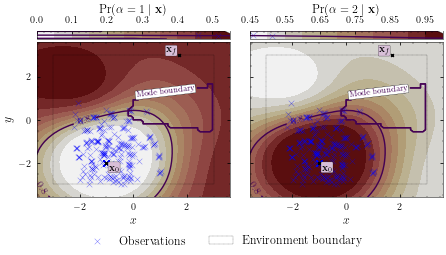

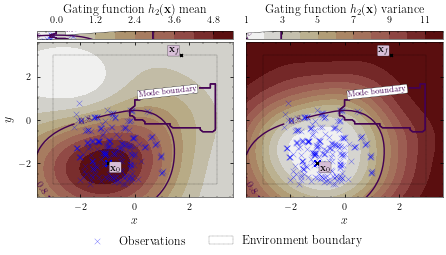

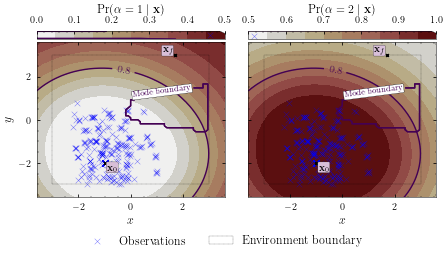

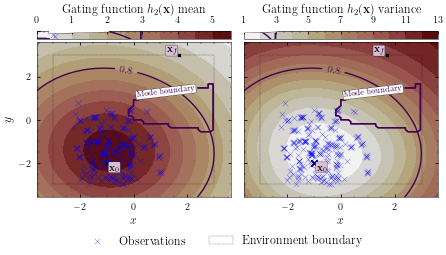

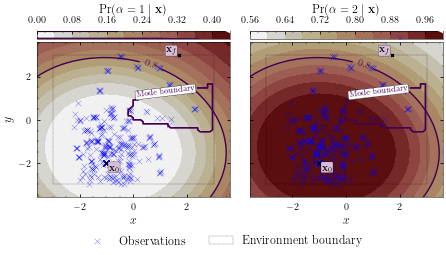

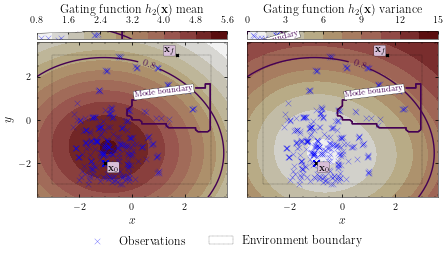

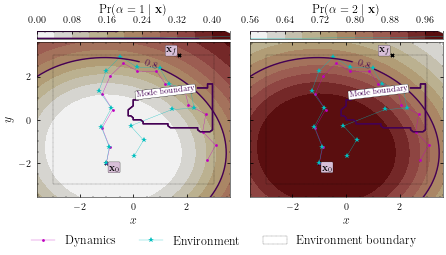

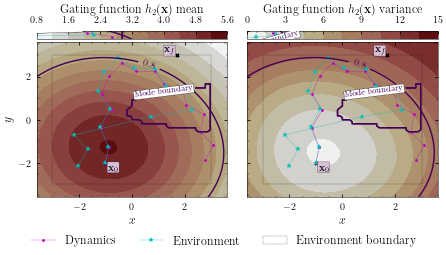

Epoch 1/10000
2/3 [===================>..........] - ETA: 0s - loss: -682.5002

2022-04-13 21:20:58.340295: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-13 21:20:58.340313: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


3/3 [==============================] - 2s 955ms/step - loss: -719.2929 - val_loss: -48.8643


2022-04-13 21:20:59.538142: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-13 21:20:59.549157: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-13 21:20:59.556596: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_20_59

2022-04-13 21:20:59.561972: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_20_59/dr-robots-mbp.local.trace.json.gz
2022-04-13 21:20:59.582826: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-13-21-01/train/plugins/profile/2022_04_13_21_20_59

2022-04-13 21:20:59.583056: I tensorflow/core/profiler/rpc/client/s

INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-13-21-01/ckpts/step_4_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
3/3 [==============================] - 0s 20ms/step - loss: -730.3929 - val_loss: -117.5928
Epoch 3/10000
3/3 [==============================] - 0s 18ms/step - loss: -607.5746 - val_loss: -76.4077
Epoch 4/10000
3/3 [==============================] - 0s 18ms/step - loss: -693.2979 - val_loss: -23.2563
Epoch 5/10000
3/3 [==============================] - 0s 18ms/step - loss: -657.7836 - val_loss: -64.0085
Epoch 6/10000
3/3 [==============================] - 0s 18ms/step - loss: -648.3522 - val_loss: -82.8226
Epoch 7/10000
3/3 [==============================] - 0s 18ms/step - loss: -706.8720 - val_loss: -161.4495
Epoch 8/10000
3/3 [==============================] - 0s 17ms/step - loss: -633.9806 - val_loss: -118.6199
Epoch 9/10000
3/3 [==============================] - 0s 17ms/step - loss: -719.8621 - val_loss: -181.4776
Epoch 10/10000
3/3 [==============================] - 0s 18ms/step - loss: -725.1008 - val_loss: -205.5658
Epoch 11/10000
3/3 [=============================

3/3 [==============================] - 0s 17ms/step - loss: -768.6193 - val_loss: -162.0834
Epoch 77/10000
3/3 [==============================] - 0s 18ms/step - loss: -699.0672 - val_loss: -142.1210
Epoch 78/10000
3/3 [==============================] - 0s 17ms/step - loss: -738.9767 - val_loss: -223.0350
Epoch 79/10000
3/3 [==============================] - 0s 18ms/step - loss: -745.2213 - val_loss: -189.2531
Epoch 80/10000
3/3 [==============================] - 0s 18ms/step - loss: -727.1666 - val_loss: -220.2590
Epoch 81/10000
3/3 [==============================] - 0s 17ms/step - loss: -777.1546 - val_loss: -224.8073
Epoch 82/10000
3/3 [==============================] - 0s 17ms/step - loss: -752.8495 - val_loss: -265.1261
Epoch 83/10000
3/3 [==============================] - 0s 17ms/step - loss: -814.0328 - val_loss: -175.8617
Epoch 84/10000
3/3 [==============================] - 0s 17ms/step - loss: -805.9054 - val_loss: -170.2868
Epoch 85/10000
3/3 [==============================] 

3/3 [==============================] - 0s 18ms/step - loss: -694.6114 - val_loss: -280.7917
Epoch 153/10000
3/3 [==============================] - 0s 17ms/step - loss: -727.4181 - val_loss: -158.6414
Epoch 154/10000
3/3 [==============================] - 0s 17ms/step - loss: -782.5833 - val_loss: -180.4474
Epoch 155/10000
3/3 [==============================] - 0s 18ms/step - loss: -752.6497 - val_loss: -209.8254
Epoch 156/10000
3/3 [==============================] - 0s 17ms/step - loss: -758.1676 - val_loss: -197.9878
Epoch 157/10000
3/3 [==============================] - 0s 18ms/step - loss: -686.6327 - val_loss: -159.1976
Epoch 158/10000
3/3 [==============================] - 0s 17ms/step - loss: -756.2036 - val_loss: -146.0886
Epoch 159/10000
3/3 [==============================] - 0s 17ms/step - loss: -659.5444 - val_loss: -140.6528
Epoch 160/10000
3/3 [==============================] - 0s 17ms/step - loss: -804.7711 - val_loss: -189.5317
Epoch 161/10000
3/3 [=======================

3/3 [==============================] - 0s 18ms/step - loss: -782.3551 - val_loss: -195.7921
Epoch 229/10000
3/3 [==============================] - 0s 18ms/step - loss: -821.3025 - val_loss: -235.9781
Epoch 230/10000
3/3 [==============================] - 0s 18ms/step - loss: -808.0981 - val_loss: -186.2062
Epoch 231/10000
3/3 [==============================] - 0s 18ms/step - loss: -760.0307 - val_loss: -270.4393
Epoch 232/10000
3/3 [==============================] - 0s 18ms/step - loss: -821.3881 - val_loss: -186.7140
Epoch 233/10000
3/3 [==============================] - 0s 18ms/step - loss: -822.6023 - val_loss: -152.7479
Epoch 234/10000
3/3 [==============================] - 0s 18ms/step - loss: -816.7738 - val_loss: -232.1759
Epoch 235/10000
3/3 [==============================] - 0s 18ms/step - loss: -803.9389 - val_loss: -179.7796
Epoch 236/10000
3/3 [==============================] - 0s 18ms/step - loss: -834.4909 - val_loss: -223.0694
Epoch 237/10000
3/3 [=======================

3/3 [==============================] - 0s 20ms/step - loss: -740.4995 - val_loss: -146.3411
Epoch 305/10000
3/3 [==============================] - 0s 20ms/step - loss: -696.9368 - val_loss: -238.1546
Epoch 306/10000
3/3 [==============================] - 0s 21ms/step - loss: -809.5672 - val_loss: 60.2767
Epoch 307/10000
3/3 [==============================] - 0s 21ms/step - loss: -573.3565 - val_loss: -138.1987
Epoch 308/10000
3/3 [==============================] - 0s 21ms/step - loss: -690.3508 - val_loss: -49.9267
Epoch 309/10000
3/3 [==============================] - 0s 20ms/step - loss: -557.2434 - val_loss: -113.4929
Epoch 310/10000
3/3 [==============================] - 0s 21ms/step - loss: -427.7343 - val_loss: -178.4559
Epoch 311/10000
3/3 [==============================] - 0s 21ms/step - loss: -649.6236 - val_loss: -208.5596
Epoch 312/10000
3/3 [==============================] - 0s 20ms/step - loss: -590.5740 - val_loss: -46.8018
Epoch 313/10000
3/3 [===========================

3/3 [==============================] - 0s 20ms/step - loss: -771.4493 - val_loss: -107.2155
Epoch 381/10000
3/3 [==============================] - 0s 20ms/step - loss: -638.0937 - val_loss: -156.7968
Epoch 382/10000
3/3 [==============================] - 0s 21ms/step - loss: -728.0396 - val_loss: -70.8014
Epoch 383/10000
3/3 [==============================] - 0s 20ms/step - loss: -730.9034 - val_loss: -144.8223
Epoch 384/10000
3/3 [==============================] - 0s 21ms/step - loss: -646.1002 - val_loss: -219.6176
Epoch 385/10000
3/3 [==============================] - 0s 21ms/step - loss: -650.0452 - val_loss: -185.3441
Epoch 386/10000
3/3 [==============================] - 0s 21ms/step - loss: -621.4793 - val_loss: -175.8563
Epoch 387/10000
3/3 [==============================] - 0s 21ms/step - loss: -700.0555 - val_loss: -115.4187
Epoch 388/10000
3/3 [==============================] - 0s 20ms/step - loss: -787.2322 - val_loss: -188.3236
Epoch 389/10000
3/3 [========================

3/3 [==============================] - 0s 20ms/step - loss: -787.3856 - val_loss: -242.5548
Epoch 457/10000
3/3 [==============================] - 0s 20ms/step - loss: -676.6695 - val_loss: -184.5759
Epoch 458/10000
3/3 [==============================] - 0s 20ms/step - loss: -723.1605 - val_loss: -218.1496
Epoch 459/10000
3/3 [==============================] - 0s 21ms/step - loss: -805.5284 - val_loss: -236.2622
Epoch 460/10000
3/3 [==============================] - 0s 21ms/step - loss: -721.0045 - val_loss: -214.5367
Epoch 461/10000
3/3 [==============================] - 0s 21ms/step - loss: -782.9586 - val_loss: -185.0545
Epoch 462/10000
3/3 [==============================] - 0s 20ms/step - loss: -701.4113 - val_loss: -133.9848
Epoch 463/10000
3/3 [==============================] - 0s 20ms/step - loss: -567.3777 - val_loss: -143.1129
Epoch 464/10000
3/3 [==============================] - 0s 21ms/step - loss: -698.4999 - val_loss: -200.6763
Epoch 465/10000
3/3 [=======================

3/3 [==============================] - 0s 22ms/step - loss: -781.8807 - val_loss: -280.0118
Epoch 533/10000
3/3 [==============================] - 0s 21ms/step - loss: -486.0061 - val_loss: 62.9519
Epoch 534/10000
3/3 [==============================] - 0s 21ms/step - loss: -166.8074 - val_loss: 33.2306
Epoch 535/10000
3/3 [==============================] - 0s 21ms/step - loss: -773.5451 - val_loss: -78.6564
Epoch 536/10000
3/3 [==============================] - 0s 21ms/step - loss: -252.4362 - val_loss: 86.9123
Epoch 537/10000
3/3 [==============================] - 0s 22ms/step - loss: -392.4322 - val_loss: -207.9566
Epoch 538/10000
3/3 [==============================] - 0s 21ms/step - loss: -565.4488 - val_loss: 307.1968
Epoch 539/10000
3/3 [==============================] - 0s 21ms/step - loss: -589.4948 - val_loss: 269.9252
Epoch 540/10000
3/3 [==============================] - 0s 23ms/step - loss: -230.2718 - val_loss: 36.9945
Epoch 541/10000
3/3 [==============================] - 

3/3 [==============================] - 0s 22ms/step - loss: -744.4553 - val_loss: -157.3203
Epoch 609/10000
3/3 [==============================] - 0s 22ms/step - loss: -514.9649 - val_loss: -33.7605
Epoch 610/10000
3/3 [==============================] - 0s 23ms/step - loss: -712.9350 - val_loss: -226.1982
Epoch 611/10000
3/3 [==============================] - 0s 22ms/step - loss: -761.5343 - val_loss: -238.5073
Epoch 612/10000
3/3 [==============================] - 0s 23ms/step - loss: -564.5325 - val_loss: -175.5082
Epoch 613/10000
3/3 [==============================] - 0s 23ms/step - loss: -505.5129 - val_loss: -216.7170
Epoch 614/10000
3/3 [==============================] - 0s 24ms/step - loss: -763.8175 - val_loss: -205.9786
Epoch 615/10000
3/3 [==============================] - 0s 23ms/step - loss: -581.5025 - val_loss: -145.9070
Epoch 616/10000
3/3 [==============================] - 0s 22ms/step - loss: -488.9104 - val_loss: -175.7386
Epoch 617/10000
3/3 [========================

3/3 [==============================] - 0s 22ms/step - loss: -799.5964 - val_loss: -252.8354
Epoch 685/10000
3/3 [==============================] - 0s 22ms/step - loss: -819.8253 - val_loss: -208.6279
Epoch 686/10000
3/3 [==============================] - 0s 22ms/step - loss: -812.4321 - val_loss: -219.7171
Epoch 687/10000
3/3 [==============================] - 0s 22ms/step - loss: -819.9438 - val_loss: -226.4975
Epoch 688/10000
3/3 [==============================] - 0s 22ms/step - loss: -836.1297 - val_loss: -233.5587
Epoch 689/10000
3/3 [==============================] - 0s 22ms/step - loss: -789.3014 - val_loss: -224.0916
Epoch 690/10000
3/3 [==============================] - 0s 22ms/step - loss: -829.6591 - val_loss: -212.7908
Epoch 691/10000
3/3 [==============================] - 0s 22ms/step - loss: -839.5955 - val_loss: -285.7909
Epoch 692/10000
3/3 [==============================] - 0s 21ms/step - loss: -849.1374 - val_loss: -233.4440
Epoch 693/10000
3/3 [=======================

3/3 [==============================] - 0s 23ms/step - loss: -563.6088 - val_loss: 5.4782
Epoch 761/10000
3/3 [==============================] - 0s 23ms/step - loss: -559.0412 - val_loss: 167.4521
Epoch 762/10000
3/3 [==============================] - 0s 23ms/step - loss: -595.5675 - val_loss: 61.7806
Epoch 763/10000
3/3 [==============================] - 0s 23ms/step - loss: -631.2199 - val_loss: 251.2625
Epoch 764/10000
3/3 [==============================] - 0s 23ms/step - loss: -642.5547 - val_loss: -108.3596
Epoch 765/10000
3/3 [==============================] - 0s 22ms/step - loss: -465.7776 - val_loss: -12.3139
Epoch 766/10000
3/3 [==============================] - 0s 23ms/step - loss: -540.5991 - val_loss: 96.4463
Epoch 767/10000
3/3 [==============================] - 0s 23ms/step - loss: -664.9835 - val_loss: -98.2728
Epoch 768/10000
3/3 [==============================] - 0s 22ms/step - loss: -685.8069 - val_loss: 463.8515
Epoch 769/10000
3/3 [==============================] - 0

3/3 [==============================] - 0s 22ms/step - loss: -551.6312 - val_loss: 14.9107
Epoch 837/10000
3/3 [==============================] - 0s 23ms/step - loss: -646.3192 - val_loss: -119.4431
Epoch 838/10000
3/3 [==============================] - 0s 23ms/step - loss: -613.4645 - val_loss: 108.1741
Epoch 839/10000
3/3 [==============================] - 0s 22ms/step - loss: -532.5228 - val_loss: 112.1658
Epoch 840/10000
3/3 [==============================] - 0s 22ms/step - loss: -675.9120 - val_loss: 29.7457
Epoch 841/10000
3/3 [==============================] - 0s 22ms/step - loss: -672.6471 - val_loss: -7.3359
Epoch 842/10000
3/3 [==============================] - 0s 22ms/step - loss: -687.3503 - val_loss: 135.9816
Epoch 843/10000
3/3 [==============================] - 0s 22ms/step - loss: -699.4394 - val_loss: 10.3692
Epoch 844/10000
3/3 [==============================] - 0s 22ms/step - loss: -621.5765 - val_loss: -54.2565
Epoch 845/10000
3/3 [==============================] - 0

Epoch 913/10000
3/3 [==============================] - 0s 23ms/step - loss: -253.2559 - val_loss: -129.3681
Epoch 914/10000
3/3 [==============================] - 0s 23ms/step - loss: -541.3865 - val_loss: 138.4711
Epoch 915/10000
3/3 [==============================] - 0s 22ms/step - loss: -506.6748 - val_loss: 238.7802
Epoch 916/10000
3/3 [==============================] - 0s 23ms/step - loss: -642.0982 - val_loss: 145.3413
Epoch 917/10000
3/3 [==============================] - 0s 23ms/step - loss: -403.9314 - val_loss: -137.5067
Epoch 918/10000
3/3 [==============================] - 0s 25ms/step - loss: -453.4238 - val_loss: 8.7425
Epoch 919/10000
3/3 [==============================] - 0s 22ms/step - loss: -299.5608 - val_loss: -130.7165
Epoch 920/10000
3/3 [==============================] - 0s 23ms/step - loss: -665.8320 - val_loss: 132.3559
Epoch 921/10000
3/3 [==============================] - 0s 23ms/step - loss: -595.1162 - val_loss: -112.7601
Epoch 922/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: -251.9621 - val_loss: -111.8189
Epoch 990/10000
3/3 [==============================] - 0s 24ms/step - loss: -304.4440 - val_loss: -61.7988
Epoch 991/10000
3/3 [==============================] - 0s 24ms/step - loss: -557.4713 - val_loss: 119.7119
Epoch 992/10000
3/3 [==============================] - 0s 24ms/step - loss: -567.7857 - val_loss: 0.5399
Epoch 993/10000
3/3 [==============================] - 0s 23ms/step - loss: -623.1591 - val_loss: -118.7627
Epoch 994/10000
3/3 [==============================] - 0s 27ms/step - loss: -508.1049 - val_loss: -98.4885
Epoch 995/10000
3/3 [==============================] - 0s 26ms/step - loss: -586.0273 - val_loss: -87.4878
Epoch 996/10000
3/3 [==============================] - 0s 24ms/step - loss: -578.6679 - val_loss: -172.1990
Epoch 997/10000
3/3 [==============================] - 0s 24ms/step - loss: -542.0850 - val_loss: -107.7796
Epoch 998/10000
3/3 [==============================

3/3 [==============================] - 0s 24ms/step - loss: -721.6257 - val_loss: -286.1472
Epoch 1065/10000
3/3 [==============================] - 0s 24ms/step - loss: -725.9174 - val_loss: -121.0775
Epoch 1066/10000
3/3 [==============================] - 0s 24ms/step - loss: -663.4673 - val_loss: -93.2755
Epoch 1067/10000
3/3 [==============================] - 0s 24ms/step - loss: -754.2159 - val_loss: 81.2255
Epoch 1068/10000
3/3 [==============================] - 0s 23ms/step - loss: -706.4084 - val_loss: -211.4545
Epoch 1069/10000
3/3 [==============================] - 0s 24ms/step - loss: -742.0307 - val_loss: -132.2496
Epoch 1070/10000
3/3 [==============================] - 0s 24ms/step - loss: -737.2680 - val_loss: -289.8555
Epoch 1071/10000
3/3 [==============================] - 0s 24ms/step - loss: -767.6473 - val_loss: -123.4914
Epoch 1072/10000
3/3 [==============================] - 0s 24ms/step - loss: -762.4221 - val_loss: -115.4902
Epoch 1073/10000
3/3 [=================

3/3 [==============================] - 0s 23ms/step - loss: -764.2264 - val_loss: -112.8271
Epoch 1140/10000
3/3 [==============================] - 0s 24ms/step - loss: -682.2859 - val_loss: -114.4262
Epoch 1141/10000
3/3 [==============================] - 0s 24ms/step - loss: -667.2406 - val_loss: -175.7165
Epoch 1142/10000
3/3 [==============================] - 0s 24ms/step - loss: -768.8660 - val_loss: -194.0529
Epoch 1143/10000
3/3 [==============================] - 0s 24ms/step - loss: -790.4364 - val_loss: -217.3076
Epoch 1144/10000
3/3 [==============================] - 0s 24ms/step - loss: -692.6789 - val_loss: -247.9447
Epoch 1145/10000
3/3 [==============================] - 0s 24ms/step - loss: -710.3599 - val_loss: -186.6860
Epoch 1146/10000
3/3 [==============================] - 0s 24ms/step - loss: -667.4233 - val_loss: -196.2887
Epoch 1147/10000
3/3 [==============================] - 0s 24ms/step - loss: -751.8913 - val_loss: -119.8929
Epoch 1148/10000
3/3 [==============

3/3 [==============================] - 0s 25ms/step - loss: -787.3509 - val_loss: -216.0891
Epoch 1215/10000
3/3 [==============================] - 0s 26ms/step - loss: -805.8608 - val_loss: -202.1563
Epoch 1216/10000
3/3 [==============================] - 0s 25ms/step - loss: -790.0580 - val_loss: -191.2547
Epoch 1217/10000
3/3 [==============================] - 0s 25ms/step - loss: -699.8080 - val_loss: -126.6044
Epoch 1218/10000
3/3 [==============================] - 0s 26ms/step - loss: -656.6142 - val_loss: -185.4389
Epoch 1219/10000
3/3 [==============================] - 0s 25ms/step - loss: -750.9508 - val_loss: -82.9554
Epoch 1220/10000
3/3 [==============================] - 0s 24ms/step - loss: -767.2974 - val_loss: -173.4753
Epoch 1221/10000
3/3 [==============================] - 0s 25ms/step - loss: -769.6953 - val_loss: -227.0405
Epoch 1222/10000
3/3 [==============================] - 0s 26ms/step - loss: -745.0920 - val_loss: -158.2008
Epoch 1223/10000
3/3 [===============

3/3 [==============================] - 0s 23ms/step - loss: -755.1947 - val_loss: -246.2837
Epoch 1290/10000
3/3 [==============================] - 0s 23ms/step - loss: -797.7903 - val_loss: -172.1687
Epoch 1291/10000
3/3 [==============================] - 0s 23ms/step - loss: -828.1505 - val_loss: -206.1219
Epoch 1292/10000
3/3 [==============================] - 0s 24ms/step - loss: -822.8687 - val_loss: -262.2317
Epoch 1293/10000
3/3 [==============================] - 0s 23ms/step - loss: -833.0327 - val_loss: -171.9268
Epoch 1294/10000
3/3 [==============================] - 0s 23ms/step - loss: -802.8401 - val_loss: -296.4666
Epoch 1295/10000
3/3 [==============================] - 0s 24ms/step - loss: -809.7350 - val_loss: -260.8052
Epoch 1296/10000
3/3 [==============================] - 0s 23ms/step - loss: -867.3371 - val_loss: -184.1166
Epoch 1297/10000
3/3 [==============================] - 0s 23ms/step - loss: -830.7728 - val_loss: -269.0451
Epoch 1298/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: -763.1839 - val_loss: -195.3521
Epoch 1365/10000
3/3 [==============================] - 0s 24ms/step - loss: -848.5639 - val_loss: 111.9360
Epoch 1366/10000
3/3 [==============================] - 0s 24ms/step - loss: -406.6155 - val_loss: -4.4465
Epoch 1367/10000
3/3 [==============================] - 0s 24ms/step - loss: -133.3328 - val_loss: -7.9707
Epoch 1368/10000
3/3 [==============================] - 0s 24ms/step - loss: 14.6730 - val_loss: -136.2290
Epoch 1369/10000
3/3 [==============================] - 0s 24ms/step - loss: -332.1083 - val_loss: 54.0442
Epoch 1370/10000
3/3 [==============================] - 0s 24ms/step - loss: -617.0364 - val_loss: -0.2642
Epoch 1371/10000
3/3 [==============================] - 0s 24ms/step - loss: -362.5765 - val_loss: -146.5447
Epoch 1372/10000
3/3 [==============================] - 0s 25ms/step - loss: -212.8131 - val_loss: -168.1124
Epoch 1373/10000
3/3 [=========================

3/3 [==============================] - 0s 25ms/step - loss: -656.5055 - val_loss: 111.9934
Epoch 1440/10000
3/3 [==============================] - 0s 26ms/step - loss: -768.5055 - val_loss: -205.4154
Epoch 1441/10000
3/3 [==============================] - 0s 25ms/step - loss: -744.8747 - val_loss: -202.1140
Epoch 1442/10000
3/3 [==============================] - 0s 26ms/step - loss: -777.7291 - val_loss: -120.7217
Epoch 1443/10000
3/3 [==============================] - 0s 25ms/step - loss: -720.3487 - val_loss: -149.7517
Epoch 1444/10000
3/3 [==============================] - 0s 25ms/step - loss: -716.0525 - val_loss: -221.2262
Epoch 1445/10000
3/3 [==============================] - 0s 25ms/step - loss: -794.2899 - val_loss: -302.0091
Epoch 1446/10000
3/3 [==============================] - 0s 25ms/step - loss: -628.5752 - val_loss: -152.4686
Epoch 1447/10000
3/3 [==============================] - 0s 25ms/step - loss: -661.9084 - val_loss: -202.2628
Epoch 1448/10000
3/3 [===============

3/3 [==============================] - 0s 23ms/step - loss: -585.6092 - val_loss: -149.9354
Epoch 1515/10000
3/3 [==============================] - 0s 23ms/step - loss: -625.2973 - val_loss: -270.6364
Epoch 1516/10000
3/3 [==============================] - 0s 23ms/step - loss: -710.2333 - val_loss: -79.6001
Epoch 1517/10000
3/3 [==============================] - 0s 23ms/step - loss: -520.6729 - val_loss: -113.8133
Epoch 1518/10000
3/3 [==============================] - 0s 23ms/step - loss: -208.1071 - val_loss: -75.8003
Epoch 1519/10000
3/3 [==============================] - 0s 23ms/step - loss: -722.2130 - val_loss: -8.3440
Epoch 1520/10000
3/3 [==============================] - 0s 23ms/step - loss: -222.3298 - val_loss: -55.1868
Epoch 1521/10000
3/3 [==============================] - 0s 23ms/step - loss: -497.2346 - val_loss: -112.7575
Epoch 1522/10000
3/3 [==============================] - 0s 22ms/step - loss: -639.2783 - val_loss: -68.6140
Epoch 1523/10000
3/3 [====================

3/3 [==============================] - 0s 23ms/step - loss: -657.1559 - val_loss: -230.1978
Epoch 1590/10000
3/3 [==============================] - 0s 23ms/step - loss: -662.4400 - val_loss: -148.4261
Epoch 1591/10000
3/3 [==============================] - 0s 23ms/step - loss: -702.9939 - val_loss: -212.0758
Epoch 1592/10000
3/3 [==============================] - 0s 23ms/step - loss: -827.5126 - val_loss: -248.2774
Epoch 1593/10000
3/3 [==============================] - 0s 23ms/step - loss: -812.8886 - val_loss: -92.3286
Epoch 1594/10000
3/3 [==============================] - 0s 23ms/step - loss: -762.8554 - val_loss: -300.4845
Epoch 1595/10000
3/3 [==============================] - 0s 23ms/step - loss: -761.4596 - val_loss: -109.6025
Epoch 1596/10000
3/3 [==============================] - 0s 23ms/step - loss: -745.3038 - val_loss: -90.8374
Epoch 1597/10000
3/3 [==============================] - 0s 23ms/step - loss: -738.0128 - val_loss: -179.9707
Epoch 1598/10000
3/3 [================

3/3 [==============================] - 0s 23ms/step - loss: -903.0193 - val_loss: -289.2521
Epoch 1665/10000
3/3 [==============================] - 0s 23ms/step - loss: -899.3354 - val_loss: -266.1290
Epoch 1666/10000
3/3 [==============================] - 0s 22ms/step - loss: -907.2496 - val_loss: -281.0389
Epoch 1667/10000
3/3 [==============================] - 0s 22ms/step - loss: -867.2413 - val_loss: -202.9591
Epoch 1668/10000
3/3 [==============================] - 0s 22ms/step - loss: -913.8733 - val_loss: -307.6686
Epoch 1669/10000
3/3 [==============================] - 0s 22ms/step - loss: -882.3047 - val_loss: -282.0786
Epoch 1670/10000
3/3 [==============================] - 0s 21ms/step - loss: -883.3294 - val_loss: -265.7739
Epoch 1671/10000
3/3 [==============================] - 0s 22ms/step - loss: -894.7032 - val_loss: -295.6018
Epoch 1672/10000
3/3 [==============================] - 0s 22ms/step - loss: -858.1211 - val_loss: -310.6011
Epoch 1673/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -516.6944 - val_loss: -171.9055
Epoch 1740/10000
3/3 [==============================] - 0s 21ms/step - loss: -401.4226 - val_loss: -103.7394
Epoch 1741/10000
3/3 [==============================] - 0s 22ms/step - loss: -426.1489 - val_loss: -230.3812
Epoch 1742/10000
3/3 [==============================] - 0s 22ms/step - loss: -619.2065 - val_loss: -205.0166
Epoch 1743/10000
3/3 [==============================] - 0s 21ms/step - loss: -659.3062 - val_loss: -176.3763
Epoch 1744/10000
3/3 [==============================] - 0s 21ms/step - loss: -547.0287 - val_loss: -217.7172
Epoch 1745/10000
3/3 [==============================] - 0s 21ms/step - loss: -694.9313 - val_loss: -147.9981
Epoch 1746/10000
3/3 [==============================] - 0s 21ms/step - loss: -602.0834 - val_loss: -181.0710
Epoch 1747/10000
3/3 [==============================] - 0s 21ms/step - loss: -586.5139 - val_loss: -93.5267
Epoch 1748/10000
3/3 [===============

3/3 [==============================] - 0s 22ms/step - loss: -637.0564 - val_loss: -61.6411
Epoch 1815/10000
3/3 [==============================] - 0s 22ms/step - loss: -757.5952 - val_loss: -246.9734
Epoch 1816/10000
3/3 [==============================] - 0s 21ms/step - loss: -761.3622 - val_loss: -248.5484
Epoch 1817/10000
3/3 [==============================] - 0s 21ms/step - loss: -718.1547 - val_loss: -214.8873
Epoch 1818/10000
3/3 [==============================] - 0s 22ms/step - loss: -773.9752 - val_loss: -189.0136
Epoch 1819/10000
3/3 [==============================] - 0s 23ms/step - loss: -772.0968 - val_loss: -193.1602
Epoch 1820/10000
3/3 [==============================] - 0s 22ms/step - loss: -714.4427 - val_loss: -200.8833
Epoch 1821/10000
3/3 [==============================] - 0s 22ms/step - loss: -753.1780 - val_loss: -254.0806
Epoch 1822/10000
3/3 [==============================] - 0s 22ms/step - loss: -740.0269 - val_loss: -185.1462
Epoch 1823/10000
3/3 [===============

3/3 [==============================] - 0s 21ms/step - loss: -763.2906 - val_loss: -214.2900
Epoch 1890/10000
3/3 [==============================] - 0s 21ms/step - loss: -753.3824 - val_loss: -183.7116
Epoch 1891/10000
3/3 [==============================] - 0s 21ms/step - loss: -721.7850 - val_loss: -214.4126
Epoch 1892/10000
3/3 [==============================] - 0s 21ms/step - loss: -776.0300 - val_loss: -262.0584
Epoch 1893/10000
3/3 [==============================] - 0s 21ms/step - loss: -769.2116 - val_loss: -189.0554
Epoch 1894/10000
3/3 [==============================] - 0s 21ms/step - loss: -787.5439 - val_loss: -292.9583
Epoch 1895/10000
3/3 [==============================] - 0s 21ms/step - loss: -654.6300 - val_loss: -166.6399
Epoch 1896/10000
3/3 [==============================] - 0s 22ms/step - loss: -772.9655 - val_loss: -212.4629
Epoch 1897/10000
3/3 [==============================] - 0s 22ms/step - loss: -630.0062 - val_loss: -269.8532
Epoch 1898/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -781.3372 - val_loss: -270.4941
Epoch 1965/10000
3/3 [==============================] - 0s 22ms/step - loss: -817.6795 - val_loss: -231.6318
Epoch 1966/10000
3/3 [==============================] - 0s 24ms/step - loss: -748.0043 - val_loss: -277.8406
Epoch 1967/10000
3/3 [==============================] - 0s 21ms/step - loss: -810.8274 - val_loss: -140.3498
Epoch 1968/10000
3/3 [==============================] - 0s 21ms/step - loss: -647.5063 - val_loss: -234.1677
Epoch 1969/10000
3/3 [==============================] - 0s 21ms/step - loss: -790.4328 - val_loss: -289.1387
Epoch 1970/10000
3/3 [==============================] - 0s 21ms/step - loss: -634.8851 - val_loss: -174.5414
Epoch 1971/10000
3/3 [==============================] - 0s 21ms/step - loss: -418.8226 - val_loss: -223.2291
Epoch 1972/10000
3/3 [==============================] - 0s 21ms/step - loss: -666.6681 - val_loss: -94.5897
Epoch 1973/10000
3/3 [===============

/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2002/10000
3/3 [==============================] - 0s 18ms/step - loss: -859.0745 - val_loss: -174.8033
Epoch 2003/10000
3/3 [==============================] - 0s 18ms/step - loss: -831.3199 - val_loss: -249.2660
Epoch 2004/10000
3/3 [==============================] - 0s 17ms/step - loss: -821.9822 - val_loss: -270.9756
Epoch 2005/10000
3/3 [==============================] - 0s 18ms/step - loss: -829.2178 - val_loss: -248.3804
Epoch 2006/10000
3/3 [==============================] - 0s 18ms/step - loss: -862.3131 - val_loss: -177.6290
Epoch 2007/10000
3/3 [==============================] - 0s 18ms/step - loss: -453.1793 - val_loss: -257.4222
Epoch 2008/10000
3/3 [==============================] - 0s 18ms/step - loss: -32.0619 - val_loss: -143.2912
Epoch 2009/10000
3/3 [==============================] - 0s 18ms/step - loss: -726.1791 - val_loss: -272.3751
Epoch 2010/10000
3/3 [==============================] - 0s 18ms/step - loss: -364.6556 - val_loss: -278.3316
Epoch 2011/10000
3/3

3/3 [==============================] - 0s 17ms/step - loss: -822.3234 - val_loss: -154.4221
Epoch 2078/10000
3/3 [==============================] - 0s 18ms/step - loss: -834.5104 - val_loss: -223.3147
Epoch 2079/10000
3/3 [==============================] - 0s 18ms/step - loss: -847.6014 - val_loss: -230.8599
Epoch 2080/10000
3/3 [==============================] - 0s 18ms/step - loss: -831.5799 - val_loss: -281.8366
Epoch 2081/10000
3/3 [==============================] - 0s 17ms/step - loss: -845.5176 - val_loss: -244.4166
Epoch 2082/10000
3/3 [==============================] - 0s 18ms/step - loss: -850.3204 - val_loss: -289.5232
Epoch 2083/10000
3/3 [==============================] - 0s 17ms/step - loss: -862.0780 - val_loss: -268.3083
Epoch 2084/10000
3/3 [==============================] - 0s 17ms/step - loss: -859.9062 - val_loss: -303.1915
Epoch 2085/10000
3/3 [==============================] - 0s 17ms/step - loss: -852.5015 - val_loss: -275.7854
Epoch 2086/10000
3/3 [==============

3/3 [==============================] - 0s 19ms/step - loss: -850.0696 - val_loss: -279.9179
Epoch 2153/10000
3/3 [==============================] - 0s 20ms/step - loss: -834.1625 - val_loss: -208.1704
Epoch 2154/10000
3/3 [==============================] - 0s 19ms/step - loss: -842.1767 - val_loss: -215.4280
Epoch 2155/10000
3/3 [==============================] - 0s 20ms/step - loss: -838.4652 - val_loss: -251.2287
Epoch 2156/10000
3/3 [==============================] - 0s 20ms/step - loss: -858.5175 - val_loss: -253.1593
Epoch 2157/10000
3/3 [==============================] - 0s 20ms/step - loss: -868.2434 - val_loss: -237.2570
Epoch 2158/10000
3/3 [==============================] - 0s 20ms/step - loss: -881.4137 - val_loss: -280.7867
Epoch 2159/10000
3/3 [==============================] - 0s 20ms/step - loss: -872.1143 - val_loss: -259.1216
Epoch 2160/10000
3/3 [==============================] - 0s 20ms/step - loss: -876.3067 - val_loss: -277.7177
Epoch 2161/10000
3/3 [==============

3/3 [==============================] - 0s 21ms/step - loss: -790.0051 - val_loss: -204.6636
Epoch 2228/10000
3/3 [==============================] - 0s 22ms/step - loss: -788.9687 - val_loss: -224.4588
Epoch 2229/10000
3/3 [==============================] - 0s 22ms/step - loss: -779.8130 - val_loss: -193.5655
Epoch 2230/10000
3/3 [==============================] - 0s 21ms/step - loss: -797.4664 - val_loss: -211.9770
Epoch 2231/10000
3/3 [==============================] - 0s 21ms/step - loss: -796.1265 - val_loss: -206.5297
Epoch 2232/10000
3/3 [==============================] - 0s 21ms/step - loss: -798.1134 - val_loss: -178.8527
Epoch 2233/10000
3/3 [==============================] - 0s 23ms/step - loss: -720.6333 - val_loss: -164.8660
Epoch 2234/10000
3/3 [==============================] - 0s 22ms/step - loss: -828.1304 - val_loss: -223.1367
Epoch 2235/10000
3/3 [==============================] - 0s 25ms/step - loss: -812.6853 - val_loss: -218.8329
Epoch 2236/10000
3/3 [==============

3/3 [==============================] - 0s 22ms/step - loss: -580.4166 - val_loss: -188.2802
Epoch 2303/10000
3/3 [==============================] - 0s 21ms/step - loss: -689.0411 - val_loss: -211.4982
Epoch 2304/10000
3/3 [==============================] - 0s 21ms/step - loss: -696.6410 - val_loss: -46.4552
Epoch 2305/10000
3/3 [==============================] - 0s 22ms/step - loss: -493.5947 - val_loss: -187.8540
Epoch 2306/10000
3/3 [==============================] - 0s 21ms/step - loss: -677.8814 - val_loss: -100.2893
Epoch 2307/10000
3/3 [==============================] - 0s 21ms/step - loss: -718.4142 - val_loss: -159.0068
Epoch 2308/10000
3/3 [==============================] - 0s 22ms/step - loss: -661.9620 - val_loss: -221.6385
Epoch 2309/10000
3/3 [==============================] - 0s 21ms/step - loss: -610.8616 - val_loss: -196.8550
Epoch 2310/10000
1/3 [=========>....................] - ETA: 0s - loss: -741.0757

In [ ]:
for step in range(1, num_steps):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": int(mode_optimiser.dataset[0].shape[0]/3)})
#     mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
for step in range(num_steps, num_steps*2):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    batch_size = mode_optimiser.dataset[0].shape[0]
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": int(mode_optimiser.dataset[0].shape[0]/3)})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch="last", save=True)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
state_diff_cost_matrix